# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

Abgabe von: <font color='blue'>Noah Leuenberger</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe Ordner "resources"
* CSCS "High-Performance Computing with Python" Kurs, Tag 3:
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [ ]:
import utils.experiments as exp

RESULTS_MANAGER = exp.ExperimentResultsManager(
    results_file="results/experiment_results.csv"
)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [ ]:
import numpy as np
import cupy as cp
import numba
import pickle
from numba import cuda, float32
from scipy.linalg import svd
import matplotlib.pyplot as plt
import time
import os
import imageio.v3 as imageio
import glob
from tqdm import tqdm
import random
import math


def load_images():
    images = np.array(
        [
            imageio.imread(f)
            for f in glob.glob(f"{os.path.join('adni_png', '001')}/*145.png")
        ]
    )
    images = (images - images.min()) / (images.max() - images.min())
    return images


def plot_reconstruction(image, C, k, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title if title else f"Reconstruction for k = {k}")

    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(C, cmap="gray")
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")
    plt.show()


# FROM PART 1
def reconstruct_cpu(u, s, vt, k):
    # def reconstruct_svd_broadcast1(u, s, vt, k):
    ### BEGIN SOLUTION
    return (u[:, :k] * s[:k]) @ vt[:k, :]
    ### END SOLUTION


images = load_images()
image = images[0]
U, S, VT = svd(image, full_matrices=False)
print(f"U: {U.shape}, S: {S.shape}, VT: {VT.shape}, image: {image.shape}")

k = 25
C = reconstruct_cpu(U, S, VT, k)
plot_reconstruction(image, C, k)

#### CuPy

In [ ]:
U_device = cp.asarray(U, dtype=np.float32)
S_device = cp.asarray(S, dtype=np.float32)
VT_device = cp.asarray(VT, dtype=np.float32)


def reconstruct_cp(u, s, vt, k):
    return cp.dot(u[:, :k], cp.dot(cp.diag(s[:k]), vt[:k, :]))


def reconstruct_cp_broadcast(u, s, vt, k):
    return cp.dot(u[:, :k], s[:k, None] * vt[:k, :])


k = 25
for reconstruction_func in [
    reconstruct_cp,
    reconstruct_cp_broadcast,
]:
    plot_reconstruction(
        image, reconstruction_func(U_device, S_device, VT_device, k).get(), k
    )

del U_device, S_device, VT_device

#### CuPy Raw Kernel

In [ ]:
kernel_code = """
extern "C" __global__
void reconstruct_svd(const float* u, const float* s, const float* vt, float* C,
            int rows_u, int cols_u, int rows_vt, int cols_vt, int k)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i < rows_u && j < cols_vt) {
        float sum = 0.0f;
        for (int l = 0; l < k; ++l) {
            sum += u[i * cols_u + l] * s[l] * vt[l * cols_vt + j];
        }
        C[i * cols_vt + j] = sum;
    }
}
"""

reconstruct_kernel = cp.RawKernel(kernel_code, "reconstruct_svd")

threads_per_block = (16, 16)
k = 25
blocks_per_grid_x = math.ceil(U.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(VT.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

U_device = cp.asarray(U, dtype=np.float32, order="C")
S_device = cp.asarray(S, dtype=np.float32, order="C")
VT_device = cp.asarray(VT, dtype=np.float32, order="C")

C_device = cp.zeros((U.shape[0], VT.shape[1]), dtype=np.float32, order="C")

reconstruct_kernel(
    blocks_per_grid,
    threads_per_block,
    (
        U_device,
        S_device,
        VT_device,
        C_device,
        U.shape[0],
        U.shape[1],
        VT.shape[0],
        VT.shape[1],
        k,
    ),
)

C = cp.asnumpy(C_device)
plot_reconstruction(image, C, k)

#### Numba

In [ ]:
@cuda.jit
def reconstruct_numba_kernel(u, s, vt, C, k):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if x < u.shape[0] and y < vt.shape[1]:
        tmp = 0
        for k_i in range(k):
            tmp += u[x, k_i] * s[k_i] * vt[k_i, y]
        C[x, y] = tmp


U_device_numba = cuda.to_device(U.astype(np.float32))
S_device_numba = cuda.to_device(S.astype(np.float32))
VT_device_numba = cuda.to_device(VT.astype(np.float32))
C_device_numba = cuda.to_device(np.zeros((U.shape[0], VT.shape[1]), dtype=np.float32))

threads_per_block = (16, 16)
k = 25

blocks_per_grid = (
    math.ceil(U.shape[0] / threads_per_block[0]),
    math.ceil(VT.shape[1] / threads_per_block[1]),
)

reconstruct_numba_kernel[blocks_per_grid, threads_per_block](
    U_device_numba, S_device_numba, VT_device_numba, C_device_numba, k
)

plot_reconstruction(image, C_device_numba.copy_to_host(), k)

#### Benchmarking

For benchamrking the CPU and GPU implementation, I will use the `timeit` module to also easily execute mutliple trials.

For all the CuPy GPU implementations, I will use the `cupyx.profiler.benchmark` function to measure the time. The function includes warmup runs and multiple trials and Cuda Events to get a more accurate measurement: https://docs.cupy.dev/en/stable/reference/generated/cupyx.profiler.benchmark.html

For Numba I have implemented my own benchmarking function `benchmark_numba_kernel`, which is inspired by the `cupyx.profiler.benchmark` function. It also includes warmup runs and multiple trials and Cuda Events to get a more accurate measurement.

In [8]:
import timeit
from cupyx.profiler import benchmark  # used for benchmarking cupy code


def benchmark_timeit(func, args, n_repeat):
    return timeit.timeit(lambda: func(*args), globals=globals(), number=n_repeat)


def benchmark_numba_kernel(
    kernel_func,
    kernel_args,
    blocks_per_grid,
    threads_per_block,
    n_warmup=10,
    n_repeat=50,
):
    for _ in range(n_warmup):
        kernel_func[blocks_per_grid, threads_per_block](*kernel_args)
    cuda.synchronize()

    gpu_times = []
    for _ in range(n_repeat):
        gpu_start_event = cuda.event()
        gpu_end_event = cuda.event()

        gpu_start_event.record()
        kernel_func[blocks_per_grid, threads_per_block](*kernel_args)
        gpu_end_event.record()

        gpu_end_event.synchronize()  # start event is already synchronized if end event is synchronized
        gpu_times.append(
            cuda.event_elapsed_time(gpu_start_event, gpu_end_event) * 1e-3
        )  # to seconds

    return {
        "gpu_times": np.array(gpu_times),
        "gpu_time_mean": np.mean(gpu_times),
    }

In [ ]:
EXPERIMENT_NAME = "Baselines"
N = 1000
ks = np.concatenate([np.arange(1, 10, 1), np.arange(10, 20, 2), np.arange(20, 170, 10)])
threads_per_block = (16, 16)
grid = (
    math.ceil(U.shape[0] / threads_per_block[0]),
    math.ceil(VT.shape[1] / threads_per_block[1]),
)

# CPU Baseline
for k in ks:
    time_cpu = benchmark_timeit(reconstruct_cpu, (U, S, VT, k), n_repeat=N)
    RESULTS_MANAGER.add_result(
        experiment=EXPERIMENT_NAME,
        implementation="CPU",
        k=k,
        time_seconds=time_cpu,
        input_size=image.shape,
        additional_info={"Repeats": N},
    )

# CuPy
for method_name, method in [
    ("CuPy dot", reconstruct_cp),
    ("CuPy broadcast", reconstruct_cp_broadcast),
]:
    for k in ks:
        time_cupy = benchmark(
            method, (U_device, S_device, VT_device, k), n_repeat=N
        ).gpu_times.sum()
        RESULTS_MANAGER.add_result(
            experiment=EXPERIMENT_NAME,
            implementation=method_name,
            k=k,
            time_seconds=time_cupy,
            input_size=image.shape,
            additional_info={"Repeats": N},
        )

# CuPy RawKernel
for k in ks:
    time_cuda = benchmark(
        reconstruct_kernel,
        (
            grid,
            threads_per_block,
            (
                U_device,
                S_device,
                VT_device,
                C_device,
                U.shape[0],
                U.shape[1],
                VT.shape[0],
                VT.shape[1],
                k,
            ),
        ),
        n_repeat=N,
    ).gpu_times.sum()
    RESULTS_MANAGER.add_result(
        experiment=EXPERIMENT_NAME,
        implementation="CuPy RawKernel",
        k=k,
        time_seconds=time_cuda,
        input_size=image.shape,
        block_size=threads_per_block,
        additional_info={"Repeats": N},
    )

# Numba
for k in ks:
    time_numba = benchmark_numba_kernel(
        reconstruct_numba_kernel,
        (
            U_device_numba,
            S_device_numba,
            VT_device_numba,
            C_device_numba,
            k,
        ),
        grid,
        threads_per_block,
        n_repeat=N,
    )["gpu_times"].sum()
    RESULTS_MANAGER.add_result(
        experiment=EXPERIMENT_NAME,
        implementation="Numba GPU",
        k=k,
        time_seconds=time_numba,
        input_size=image.shape,
        block_size=threads_per_block,
        additional_info={"Repeats": N},
    )

RESULTS_MANAGER.plot_line(
    experiment_name=EXPERIMENT_NAME,
    x_col="k",
    y_col="Time [s]",
    logy=True,
    hue_col="Implementation",
    title="SVD Reconstruction Baseline Performance Comparison",
)

<font color='blue'>
The computation was divided between the CPU and GPU as follows:

- CPU: Handles the decomposition of the matrix into its singular values and matrices. Moreover the CPU is involved in tranfering the data between the host and the device (which uses CPU cycles but not).
- GPU: Handles the reconstruction itself of the calculating the product $U \cdot \Sigma \cdot V^T$.

Approaches:
1. CPU: The CPU implementation is based on the NumPy implementation from the first part.
2. CuPy:
   - Drop in replacement for NumPy with broadcasting and explicit version using `cupy.dot`.
   - Suited for vectorized code (e.g., code based on NumPy).
   - Acts as a near drop-in replacement for NumPy, allowing for minimal code changes.
3. Numba:
   - `@cuda.jit` decorator for GPU acceleration. This actually compiles the code to CUDA code that then runs on the GPU.
   - Ideal for non-vectorized code (e.g., loops) as it compiles the code (`@cuda.jit` decorator) to run on the GPU.
   - Offers a pythonic way to write CUDA code.

Each method was benchmarked for varying values of $k$ and $n = 1000$ repetitions for statistical robustness. For the Kernel implementations, I explicitly set a block size of $16x16$, and the grid size was calculated based on the matrix size and block size (ceil(matrix_size/block_size)).

It seems like the CuPy RawKernel is the fastest through all values of $k$. The CPU implemnetation shows a tendency to be faster than most of the GOU implementations for small values of $k$. For larger values of $k$ the CPU shows a clear increasing trend.

It is interesting that the CuPy RawKernel is faster than the CPU implementation for all values of $k$ as I expect it to be actually slower (at least for small values of $k$) as there is an overhead for the kernel launch. But as we do not measure in the transfer time between the host and the device, the GPU implementation perhaps has an advantage here.

The Numba implementation, although identical to the CuPy RawKernel, is slower for all values of $k$. Perhaps there are some Numba shananigans going on here but I am not sure what is causing this. It is interesting to see as I would expect them to be very similar in performance.

Braindump from future self: the self implemented GPU kernels might scale not constantly over the observed range of $k$ as memory access pattern is very naive and not optimized thus as we have to calculate more and more values for the reconstruction, the memory access pattern might become more and more important. This could be a reason why the GPU implementations are slower than the CPU implementation for larger values of $k$.

Intrestingly enough, the CuPy dot and CuPy broadcast implementations fairly consistent in their performance over all values of $k$. I am not sure how to explain this apart from the assumptions that these implementations are out of the box very optimized.
</font>

#### 5.2 GPU-Kernel Performance

##### 5.2.1 Blocks und Input-Grösse

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

First I setup the data and helper functions for all following tasks.

In [ ]:
def generate_random_image(size):
    return np.random.rand(size, size).astype(np.float32)


def create_test_images():
    return {
        f"test_image_{size}": generate_random_image(size)
        for size in [2**x for x in [10, 11, 12]]
    }


def perform_svd_on_images(images):
    decompositions = {}
    for name, image in tqdm(images.items(), desc="SVD on device", unit="image"):
        image_gpu = cp.asarray(image, dtype=np.float32)
        u_gpu, s_gpu, vt_gpu = cp.linalg.svd(image_gpu, full_matrices=False)

        decompositions[name] = {
            "u": cp.asnumpy(u_gpu),
            "s": cp.asnumpy(s_gpu),
            "vt": cp.asnumpy(vt_gpu),
        }

        # release GPU memory
        del u_gpu, s_gpu, vt_gpu, image_gpu

    return decompositions


def get_experiment_k(U_shape, VT_shape):
    return min(U_shape[1], VT_shape[0]) // 3  # use 1/3 of the minimum dimension for k


DECOMPOSITIONS = perform_svd_on_images(create_test_images())

pwd = os.getcwd()
decomposition_path = f"{pwd}/data/images.pkl"
os.makedirs(os.path.dirname(decomposition_path), exist_ok=True)
with open(decomposition_path, "wb") as f:
    pickle.dump(DECOMPOSITIONS, f)


# Establish a baseline for the CPU implementation
N_REPEAT = 50
for image_name, decomposition in DECOMPOSITIONS.items():
    U, S, VT = decomposition["u"], decomposition["s"], decomposition["vt"]
    k = get_experiment_k(U.shape, VT.shape)
    input_size = f"{U.shape[0]}x{VT.shape[1]}"

    time_cpu = (
        benchmark_timeit(reconstruct_cpu, (U, S, VT, k), n_repeat=N_REPEAT) / N_REPEAT
    )

    RESULTS_MANAGER.add_result(
        experiment="CPU",
        implementation="CPU",
        k=k,
        time_seconds=time_cpu,
        input_size=input_size,
        additional_info={
            "Repeats": N_REPEAT,
        },
    )
    print(f"CPU, image @ {input_size}, k = {k}: {time_cpu:.2e} s")


# block sizes that are powers of 2 from 2^2 to 2^5 with variations
def gen_block_configs():
    for i in range(2, 6):
        yield (2**i, 2**i)
        yield (2**i, 2 ** (i - 1))
        yield (2 ** (i - 1), 2**i)
        yield (2 ** (i - 1), 2 ** (i + 1))
        yield (2 ** (i - 2), 2 ** (i + 1))
        yield (2 ** (i - 2), 2 ** (i + 2))


print(f"Block configs: {list(gen_block_configs())}")

In [ ]:
EXPERIMENT_NAME = "Block Size"
N_REPEAT = 50

benchmark_results = []
for image_name, decomposition in DECOMPOSITIONS.items():
    U, S, VT = decomposition["u"], decomposition["s"], decomposition["vt"]
    k = get_experiment_k(U.shape, VT.shape)

    U_device = cuda.to_device(U.astype(np.float32))
    S_device = cuda.to_device(S.astype(np.float32))
    VT_device = cuda.to_device(VT.astype(np.float32))
    C_device = cuda.device_array((U.shape[0], VT.shape[1]), dtype=np.float32)

    for block_size in gen_block_configs():
        threads_per_block = block_size
        grid = (
            math.ceil(U.shape[0] / threads_per_block[0]),
            math.ceil(VT.shape[1] / threads_per_block[1]),
        )
        input_size = f"{U.shape[0]}x{VT.shape[1]}"

        print(f"GPU, image @ {input_size}, block_size {block_size}, grid {grid}")

        time_gpu = benchmark_numba_kernel(
            reconstruct_numba_kernel,
            (
                U_device,
                S_device,
                VT_device,
                C_device,
                k,
            ),
            grid,
            threads_per_block,
            n_repeat=N_REPEAT,
        )["gpu_times"].mean()

        RESULTS_MANAGER.add_result(
            experiment=EXPERIMENT_NAME,
            implementation="Numba GPU Kernel",
            k=k,
            time_seconds=time_gpu,
            input_size=input_size,
            block_size=threads_per_block,
            additional_info={
                "Grid": grid,
            },
        )

    # release GPU memory
    del U_device, S_device, VT_device, C_device

In [ ]:
for _, d in DECOMPOSITIONS.items():
    input_size = f"{d['u'].shape[0]}x{d['vt'].shape[1]}"
    RESULTS_MANAGER.plot_block_size_vs_time(
        experiment_name=EXPERIMENT_NAME,
        implementation_filter="Numba GPU Kernel",
        inputsize_filter=input_size,
        sort_by_time=True,
        logy=True,
        reference_cpu=True,
        title=f"Block Size Performance @ ({input_size})",
    )

<font color='blue'>

When comparing different block sizes, the results show that very small blocks (e.g., $8 \times 8$ or $4 \times 4$) are slower because they achieve poor warp utilization and often result in high block-management overhead. On the other hand, large blocks (e.g., $32 \times 32$) better leverage the 32-thread warp structure but can reduce the total number of blocks per GPU, potentially limiting the utilization of streaming multiprocessors (SMs).

I guess it comes down to choosing a block size that is a multiple of 32 threads per dimension to maximize warp utilization. This ensures warps are filled efficiently and minimizes the number of inactive threads. At the same time, balance is needed—larger blocks are less flexible for scheduling and may reduce the number of active blocks per SM. The optimal block size often lies "in the middle," such as $16 \times 16$ or a total block size of 256–512 threads per block given the results of the experiment.

The observation that the CPU is faster for some block sizes or smaller matrices can perhaps be attributed to the overhead of GPU kernel launches and host-to-device data transfers, as well as suboptimal memory access patterns on the GPU. However, once the workload is sufficiently large and GPU memory access is well-coordinated, the GPU kernel can significantly outperform the CPU.

This helped me:
- https://softwareengineering.stackexchange.com/a/369978
- around the section in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#occupancy-calculator

</font>

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [ ]:
TILE_SIZE = 16
BLOCK_SIZE = (TILE_SIZE, TILE_SIZE)


@cuda.jit
def reconstruct_shared_memory(u, s, vt, C, k):
    # nice visual explanations: https://siboehm.com/articles/22/CUDA-MMM
    x, y = cuda.grid(2)
    if x >= u.shape[0] or y >= vt.shape[1]:
        return

    thread_x, thread_y = cuda.threadIdx.x, cuda.threadIdx.y

    u_shared = cuda.shared.array(shape=(TILE_SIZE, TILE_SIZE), dtype=float32)
    vt_shared = cuda.shared.array(shape=(TILE_SIZE, TILE_SIZE), dtype=float32)
    s_shared = cuda.shared.array(shape=(TILE_SIZE,), dtype=float32)

    max_blocks = math.ceil(
        k / TILE_SIZE
    )  # or cuda.gridDim.x as we tie the tile size to the block size
    acc = float32(0.0)
    for block_i in range(max_blocks):
        u_shared[thread_x, thread_y] = u[x, block_i * TILE_SIZE + thread_y]
        s_shared[thread_x] = s[block_i * TILE_SIZE + thread_x]
        vt_shared[thread_x, thread_y] = vt[block_i * TILE_SIZE + thread_x, y]

        cuda.syncthreads()

        for n in range(TILE_SIZE):
            acc += u_shared[thread_x, n] * s_shared[n] * vt_shared[n, thread_y]

        cuda.syncthreads()

    C[x, y] = acc


U, S, VT = svd(image, full_matrices=False)
U_device_numba = cuda.to_device(U.astype(np.float32))
S_device_numba = cuda.to_device(S.astype(np.float32))
VT_device_numba = cuda.to_device(VT.astype(np.float32))
C_device_numba = cuda.device_array((U.shape[0], VT.shape[1]), dtype=np.float32)

grid = (
    math.ceil(U.shape[0] / BLOCK_SIZE[0]),
    math.ceil(VT.shape[1] / BLOCK_SIZE[1]),
)

print(f"total number of threads: {grid[0] * BLOCK_SIZE[0] * grid[1] * BLOCK_SIZE[1]}")
k = get_experiment_k(U.shape, VT.shape)

reconstruct_shared_memory[grid, BLOCK_SIZE](
    U_device_numba, S_device_numba, VT_device_numba, C_device_numba, k
)
cuda.synchronize()

plot_reconstruction(image, C_device_numba.copy_to_host(), k)

For the sake of simplicity, I will only run the subsequent tasks with the same block size config of $16\text{x}16$, which is a good compromise between performance and memory usage and a common choice: https://arc.net/l/quote/bymeyghw

In [ ]:
EXPERIMENT_NAME = "Shared Memory"
N_REPEAT = 50
TILE_SIZE = 16
BLOCK_SIZE = (TILE_SIZE, TILE_SIZE)

for image_name, decomposition in DECOMPOSITIONS.items():
    U, S, VT = decomposition["u"], decomposition["s"], decomposition["vt"]
    input_size = f"{U.shape[0]}x{VT.shape[1]}"
    k = get_experiment_k(U.shape, VT.shape)

    U_device = cuda.to_device(U.astype(np.float32))
    S_device = cuda.to_device(S.astype(np.float32))
    VT_device = cuda.to_device(VT.astype(np.float32))
    C_device = cuda.device_array((U.shape[0], VT.shape[1]), dtype=np.float32)

    grid = (
        math.ceil(U.shape[0] / BLOCK_SIZE[0]),
        math.ceil(VT.shape[1] / BLOCK_SIZE[1]),
    )

    print(f"GPU Shared @ {input_size}, block_size {BLOCK_SIZE}, grid {grid}")

    time_shared = benchmark_numba_kernel(
        reconstruct_shared_memory,
        (
            U_device,
            S_device,
            VT_device,
            C_device,
            k,
        ),
        grid,
        BLOCK_SIZE,
        n_repeat=N_REPEAT,
    )["gpu_times"].mean()

    RESULTS_MANAGER.add_result(
        experiment=EXPERIMENT_NAME,
        implementation="GPU Shared",
        k=k,
        time_seconds=time_shared,
        input_size=f"{U.shape[0]}x{VT.shape[1]}",
        block_size=BLOCK_SIZE,
        additional_info={
            "Grid": grid,
            "Repeats": N_REPEAT,
        },
    )

    # release GPU memory
    del U_device, S_device, VT_device, C_device

In [ ]:
RESULTS_MANAGER.plot_fastest_runs(
    experiment_names=["CPU", "Block Size", EXPERIMENT_NAME],
    x_col="InputSize",
    logy=True,
    title="Fastest Runs by Input Size",
)

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

<font color='blue'>

The shared memory implementation improves the performance compared to the naive kernel used before. This by reducing the frequency of global memory accesses (halving it). Instead of repeatedly fetching data for $U$, $S$, and $V^T$ from global memory, the kernel loads the required data into shared memory once per tile. Shared memory is much faster than global memory, so this change substantially lowers memory access latency.

Additionally, shared memory enables data reuse within a block. Once the data for a tile is loaded, all threads in the block can repeatedly access it for their computations without needing to fetch it again from global memory. For instance, the same tile of $U$, $S$, and $V^T$ remains available for all iterations in the inner loop over $n$.

The big picture remains the same: the GPU implementation is faster for the smallest block size. For larger block sizes, the CPU implementation is faster. This kind of makes sense as the shared memory implementation is not optimized yet for coalesced memory access patterns. This is a possible explanation why the CPU implementation is faster for larger block sizes.

</font>

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

In [ ]:
TILE_SIZE_M, TILE_SIZE_N = 16, 16
TILE_SIZE_K = int(TILE_SIZE_M / 2)

# how many threads we take to manage a tile
THREAD_TILE_M = int(TILE_SIZE_M / 4)
THREAD_TILE_N = int(TILE_SIZE_N / 4)


@cuda.jit
def reconstruct_shared_memory_reuse(U, S, VT, C, M, N, K):
    # the tile is per block
    # the threads are per tile
    # we have to manage the tile in a way that we can reuse the shared memory using less threads than the elements in the tile
    # a thread basically manages a sub tile of a tile of the output matrix

    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    tx = cuda.threadIdx.x

    threads_per_tile = (TILE_SIZE_M * TILE_SIZE_N) // (THREAD_TILE_M * THREAD_TILE_N)
    if threads_per_tile != cuda.blockDim.x:
        return  # we have to many threads to manage the tile

    # within thread block indices
    thread_row = tx // (TILE_SIZE_N // THREAD_TILE_N)
    thread_col = tx % (TILE_SIZE_N // THREAD_TILE_N)

    # pointers to the start of the row and column of the output matrix
    # we take y as the row index and x as the column index
    # this allows us to make a more coalesced access to the global memory
    row_start = by * TILE_SIZE_M
    col_start = bx * TILE_SIZE_N

    # Shared memory arrays for tiles of U and VT
    U_shared = cuda.shared.array(shape=(TILE_SIZE_M, TILE_SIZE_K), dtype=float32)
    VT_shared = cuda.shared.array(shape=(TILE_SIZE_K, TILE_SIZE_N), dtype=float32)

    local_acc = cuda.local.array(shape=(THREAD_TILE_M, THREAD_TILE_N), dtype=float32)

    for k_tile_start in range(0, K, TILE_SIZE_K):
        load_idx = tx
        while load_idx < TILE_SIZE_M:
            for kk in range(TILE_SIZE_K):
                global_k = k_tile_start + kk
                if global_k < K and (row_start + load_idx) < M:
                    U_shared[load_idx, kk] = U[row_start + load_idx, global_k]
                else:
                    U_shared[load_idx, kk] = float32(0.0)
            load_idx += threads_per_tile

        load_idx = tx
        while load_idx < TILE_SIZE_N:
            for kk in range(TILE_SIZE_K):
                global_k = k_tile_start + kk
                if global_k < K and (col_start + load_idx) < N:
                    VT_shared[kk, load_idx] = (
                        VT[global_k, col_start + load_idx]
                        * S[
                            global_k
                        ]  # we multiply by S here so we dont have to manage an extra shared memory array
                    )
                else:
                    VT_shared[kk, load_idx] = float32(0.0)
            load_idx += threads_per_tile

        cuda.syncthreads()

        for dot_idx in range(TILE_SIZE_K):
            # dot_idx is basically the number
            for i in range(THREAD_TILE_M):
                row_u = thread_row * THREAD_TILE_M + i
                u_val = U_shared[row_u, dot_idx]

                # keeping the u values fixed and make the produts with all available vt values
                for j in range(THREAD_TILE_N):
                    col_vt = thread_col * THREAD_TILE_N + j
                    local_acc[i, j] += u_val * VT_shared[dot_idx, col_vt]

        cuda.syncthreads()

    for i in range(THREAD_TILE_M):
        global_row = row_start + thread_row * THREAD_TILE_M + i
        if global_row < M:
            for j in range(THREAD_TILE_N):
                global_col = col_start + thread_col * THREAD_TILE_N + j
                if global_col < N:
                    C[global_row, global_col] = local_acc[i, j]


U, S, VT = svd(image, full_matrices=False)

U_device_numba = cuda.to_device(U.astype(np.float32))
S_device_numba = cuda.to_device(S.astype(np.float32))
VT_device_numba = cuda.to_device(VT.astype(np.float32))
C_device_numba = cuda.device_array((U.shape[0], VT.shape[1]), dtype=np.float32)

N, M = U.shape[0], VT.shape[1]
threads_per_tile = (TILE_SIZE_M * TILE_SIZE_N) // (THREAD_TILE_M * THREAD_TILE_N)

block_dim = threads_per_tile
grid_dim = (math.ceil(M / TILE_SIZE_M), math.ceil(N / TILE_SIZE_N))
k = 12

print(
    f"Grid: {grid_dim}, Block: {block_dim}, Total threads: {grid_dim[0] * grid_dim[1] * block_dim}"
)

reconstruct_shared_memory_reuse[grid_dim, block_dim](
    U_device_numba,
    S_device_numba,
    VT_device_numba,
    C_device_numba,
    U.shape[0],
    VT.shape[1],
    k,
)
cuda.synchronize()

plot_reconstruction(image, C_device_numba.copy_to_host(), k)

In the previous shared memory approach, each thread block processed a $16 \times 16$ tile, where the computations for $U$, $S$, and $V^T$ were loaded into shared memory for each tile. I have now additionally subdivided the computation grid itself into multiple **dimensional tiles**:

- **$\text{TILE\_SIZE\_M}, \text{TILE\_SIZE\_N}$** define the tile dimensions in the $M$- and $N$-directions (height and width of the output) in the same way as before.
- **$\text{TILE\_SIZE\_K}$** splits the summation into blocks of dimension $K$, allowing the inner products to be computed in portions.
- **$\text{THREAD\_TILE\_M}, \text{THREAD\_TILE\_N}$** indicate that individual threads handle even smaller sub-sections of the tile. Each thread processes multiple elements within its tile area and uses a local buffer (`local_acc`) before writing the results back to global memory.

This multi-level tiling and thread subdivision further reduces the number of global memory accesses and helps better bundle shared memory accesses. As a result, data reuse is increased. 

The implementation is inspired by https://siboehm.com/articles/22/CUDA-MMM which moreover visualizes the tiling and thread subdivision in a nice way.

For example the visualization of how the thread tiles within the block tiles are acting on the matrices:

![](https://siboehm.com/assets/img/CUDA-MMM/kernel_5_reg_blocking.png)


In [ ]:
EXPERIMENT_NAME = "Shared Memory Improved"
N_REPEAT = 50
TILE_SIZE_M, TILE_SIZE_N = 16, 16
TILE_SIZE_K = int(TILE_SIZE_M / 2)
THREAD_TILE_M = int(TILE_SIZE_M / 4)
THREAD_TILE_N = int(TILE_SIZE_N / 4)

for image_name, decomposition in DECOMPOSITIONS.items():
    U, S, VT = decomposition["u"], decomposition["s"], decomposition["vt"]
    k_val = get_experiment_k(U.shape, VT.shape)
    input_size = f"{U.shape[0]}x{VT.shape[1]}"

    U_device = cuda.to_device(U.astype(np.float32))
    S_device = cuda.to_device(S.astype(np.float32))
    VT_device = cuda.to_device(VT.astype(np.float32))
    C_device = cuda.device_array((U.shape[0], VT.shape[1]), dtype=np.float32)

    N, M = U.shape[0], VT.shape[1]
    threads_per_tile = (TILE_SIZE_M * TILE_SIZE_N) // (THREAD_TILE_M * THREAD_TILE_N)
    block_dim = threads_per_tile
    grid_dim = (math.ceil(M / TILE_SIZE_M), math.ceil(N / TILE_SIZE_N))
    k = 12

    print(
        f"GPU Shared Improved @ {input_size}, block_size {block_dim}, grid {grid_dim}, total threads: {grid_dim[0] * grid_dim[1] * block_dim}"
    )

    time_shared = benchmark_numba_kernel(
        reconstruct_shared_memory_reuse,
        (U_device, S_device, VT_device, C_device, U.shape[0], VT.shape[1], k_val),
        grid_dim,
        block_dim,
        n_repeat=N_REPEAT,
    )["gpu_times"].mean()

    RESULTS_MANAGER.add_result(
        experiment=EXPERIMENT_NAME,
        implementation="GPU Shared Memory Improved",
        k=k_val,
        time_seconds=time_shared,
        input_size=input_size,
        block_size=block_dim,
        additional_info={
            "Grid": grid_dim,
            "Repeats": N_REPEAT,
        },
    )

In [ ]:
EXPERIMENT_NAME = "Shared Memory Improved"

RESULTS_MANAGER.plot_fastest_runs(
    experiment_names=[
        "CPU",
        "Block Size",
        "Shared Memory",
        EXPERIMENT_NAME,
    ],
    x_col="InputSize",
    logy=True,
    title="Fastest Runs by Input Size",
)

We can see that this implementation is faster than the shared memory implementation and faster than the CPU implementation for input sizes. The performance gain is actually huge when compared to the "naive" shared memory and the naive kernel implementation.

I think even more could be gained by tuning the tile size as well as the thread tile size. This could then further increase the occupancy of the GPU and thus the performance by making sure, that a sweet spot is between the total number of threads and the number of threads per tile.

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen.

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

First, I will look at the naive kernel implementation and see what is going on there.

The code down below is written in files so that I can run the profiling both with Nsight Systems and Nsight Compute through the command line. For all the profiling I use the largest of the randomly generated matrices ($2^{12} \text{x} 2^{12}$).

In [ ]:
%%writefile profiling/implementations/baseline.py

from numba import cuda, float32
import math
import os
import pandas as pd
import numpy as np
import sys
import cupy as cp

pwd = os.getcwd()

def load_decompositions(
    filepath=f"{pwd}/data/images.pkl",
):
    if os.path.exists(filepath):
        return pd.read_pickle(filepath)
    return None

decompositions = load_decompositions()
if decompositions is None:
    print("No decompositions found. Run part2.py first.")
    sys.exit(1)

decomposition = max(decompositions.values(), key=lambda d: len(d["s"]))
U, S, VT = decomposition["u"], decomposition["s"], decomposition["vt"]

U_device = cp.array(U, dtype=cp.float32)
S_device = cp.array(S, dtype=cp.float32)
VT_device = cp.array(VT, dtype=cp.float32)

C = np.zeros((U.shape[0], VT.shape[1]), dtype=np.float32)

print(
    f"U shape: {U.shape}, S shape: {S.shape}, VT shape: {VT.shape}, C shape: {C.shape}"
)

k = min(U.shape[1], VT.shape[0]) // 3
print(f"Using k={k}")


# --- Kernel ---

BLOCK_SIZE = (16, 16)

threads_per_block = BLOCK_SIZE
blocks_per_grid = (
    math.ceil(U.shape[0] / threads_per_block[0]),
    math.ceil(VT.shape[1] / threads_per_block[1]),
)
print(f"Threads per block: {threads_per_block}, Blocks per grid: {blocks_per_grid}")

@cuda.jit
def rec(u, s, vt, reco, k):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if x < u.shape[0] and y < vt.shape[1]:
        tmp = 0
        for k_i in range(k):
            tmp += u[x, k_i] * s[k_i] * vt[k_i, y]
        reco[x, y] = tmp

# --------------

start_time = cuda.event()
end_time = cuda.event()

start_time.record()
rec[blocks_per_grid, threads_per_block](U_device, S_device, VT_device, C, k)
end_time.record()

cuda.synchronize()
print(f"Done. Execution time: {start_time.elapsed_time(end_time)} ms")

In [ ]:
!sudo nsys profile \
  --trace cuda,osrt,nvtx \
  --gpu-metrics-device=all \
  --cuda-memory-usage true \
  --force-overwrite true \
  --output "$(pwd)/profiling/profiles/baseline" \
  $(pwd)/.venv/bin/python $(pwd)/profiling/implementations/baseline.py 16 16

!sudo /opt/nvidia/nsight-compute/2023.3.1/ncu \
  -o $(pwd)/profiling/profiles/baseline -f \
  --nvtx \
  --call-stack \
  --target-processes all \
  --metrics all \
  --set full \
  $(pwd)/.venv/bin/python $(pwd)/profiling/implementations/baseline.py 16 16

In Nsight Systems I can see that the ratio between the memory tranfer (HtoD and DtoH) and the kernel execution. The transfers from host to device and vice versa are taking up roughly 20% of the time with the rest being the kernel execution.

This is interesting as I would expect the memory transfers to be the bottleneck but the memory related issues are probably how the memory is accessed and managed within the kernel. This is something that I cannot see in the Nsight Systems profiler.

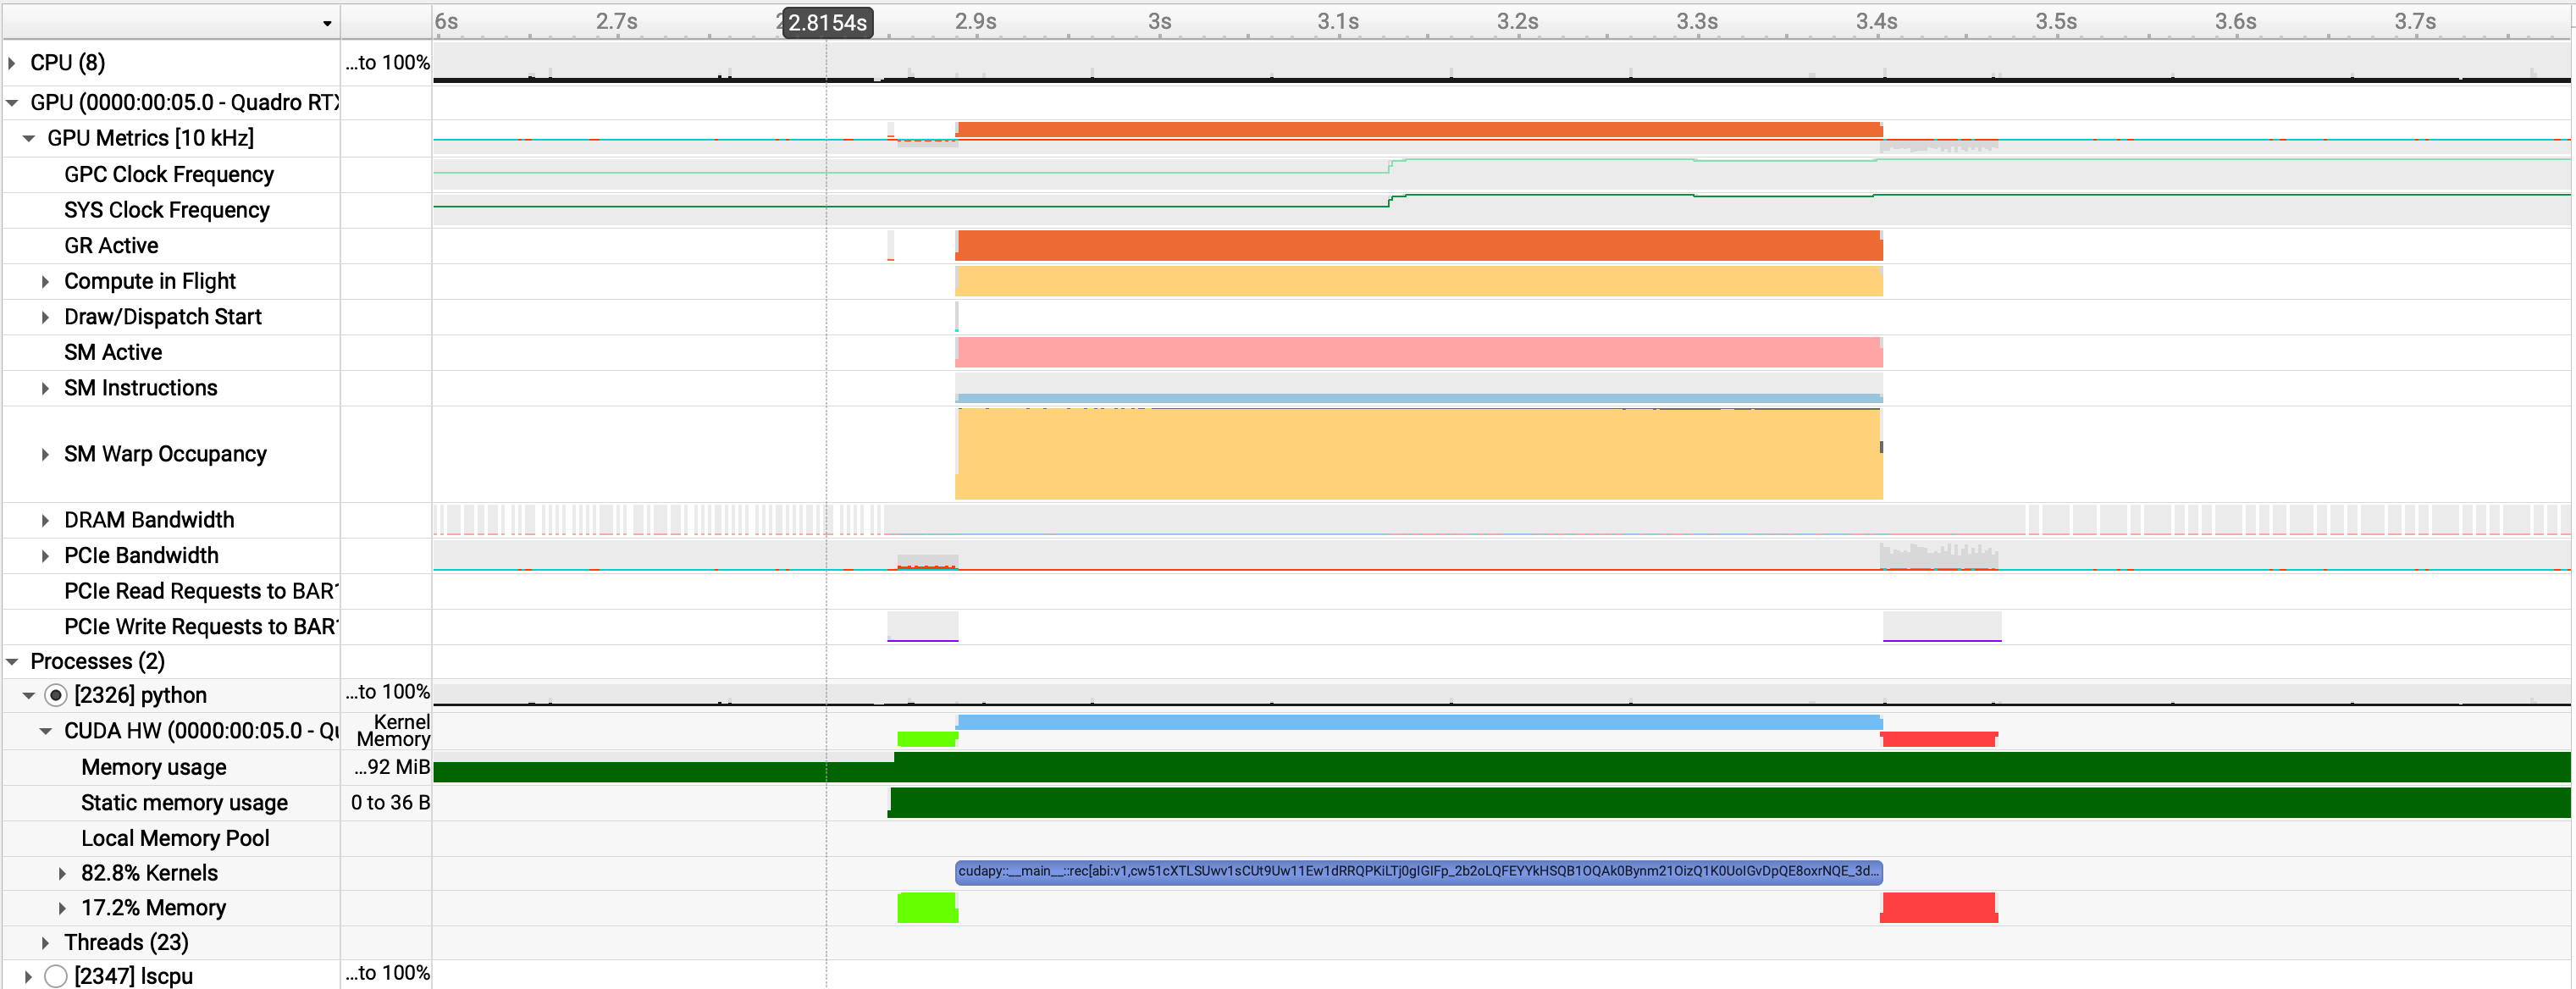


In Nsight compute the supsected problem with memory access gets apparent. The tool suggests, that an estimated 50% in performance could be gained when coalescing the memory access patterns. This is a clear indicator that the memory access pattern is not optimal and that the memory access is a major bottleneck in the kernel. 

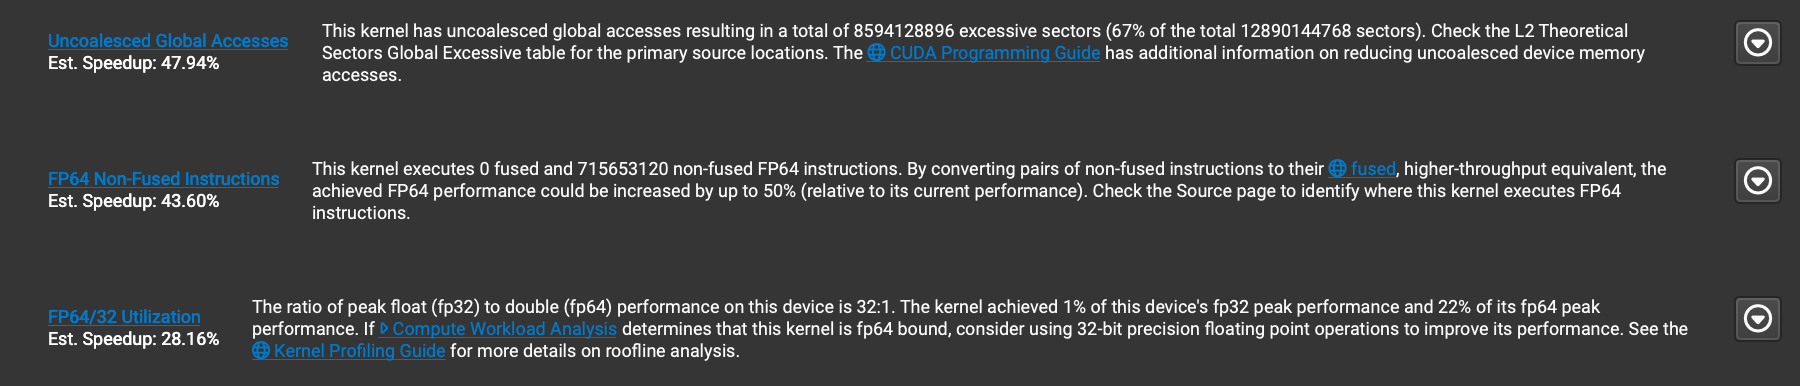

Digging deeper in the details tab of the profiler, I can see that the FP64 take up a lot of time of the workload although the kernel I assumed we are using FP32. Reflecting on it this is perhaps due to the fact that the local accumulator used in the kernel is of type `float64` when initialized like `acc = 0.0` and thus forces the kernel to use FP64. This is a clear bottleneck in the kernel and should be changed to `float32` which then in theory should reduce the memory footprint and increase the performance.

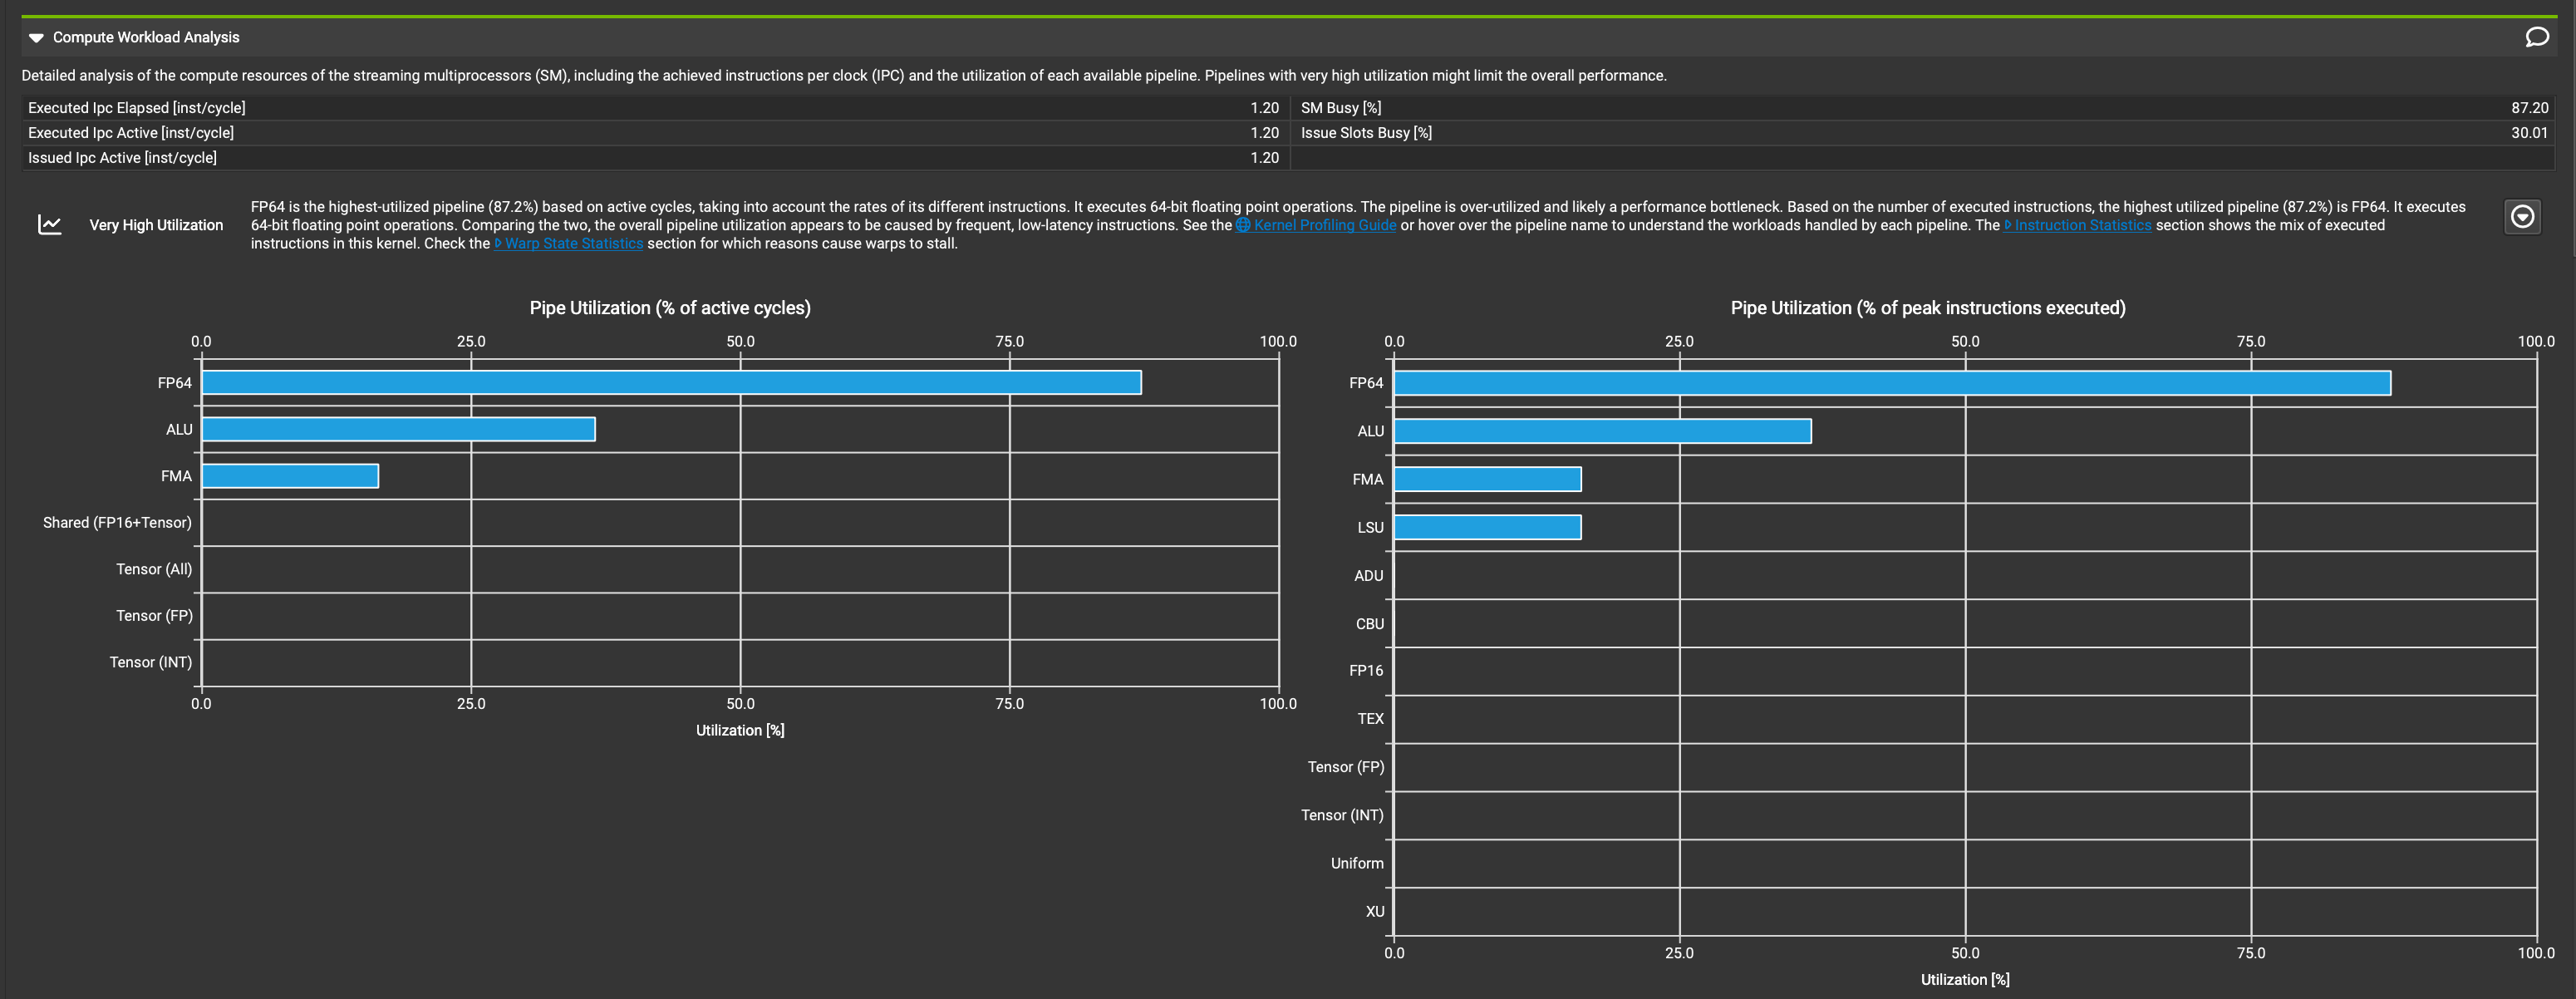

Moreover the memory chart I can see on the left that all the memory access from the kernel happen through the global memory. This is expected as we dont have any shared memory implementation in the kernel. A total of almost 6GB of memory from the global memory were requested. Interestingly a lot of the memory operations hit the L1 / L2 caches which is a good thing as it reduces the latency of the memory access. There we can also see that the most transfer is happening from the L2 cache to the L1 cache.

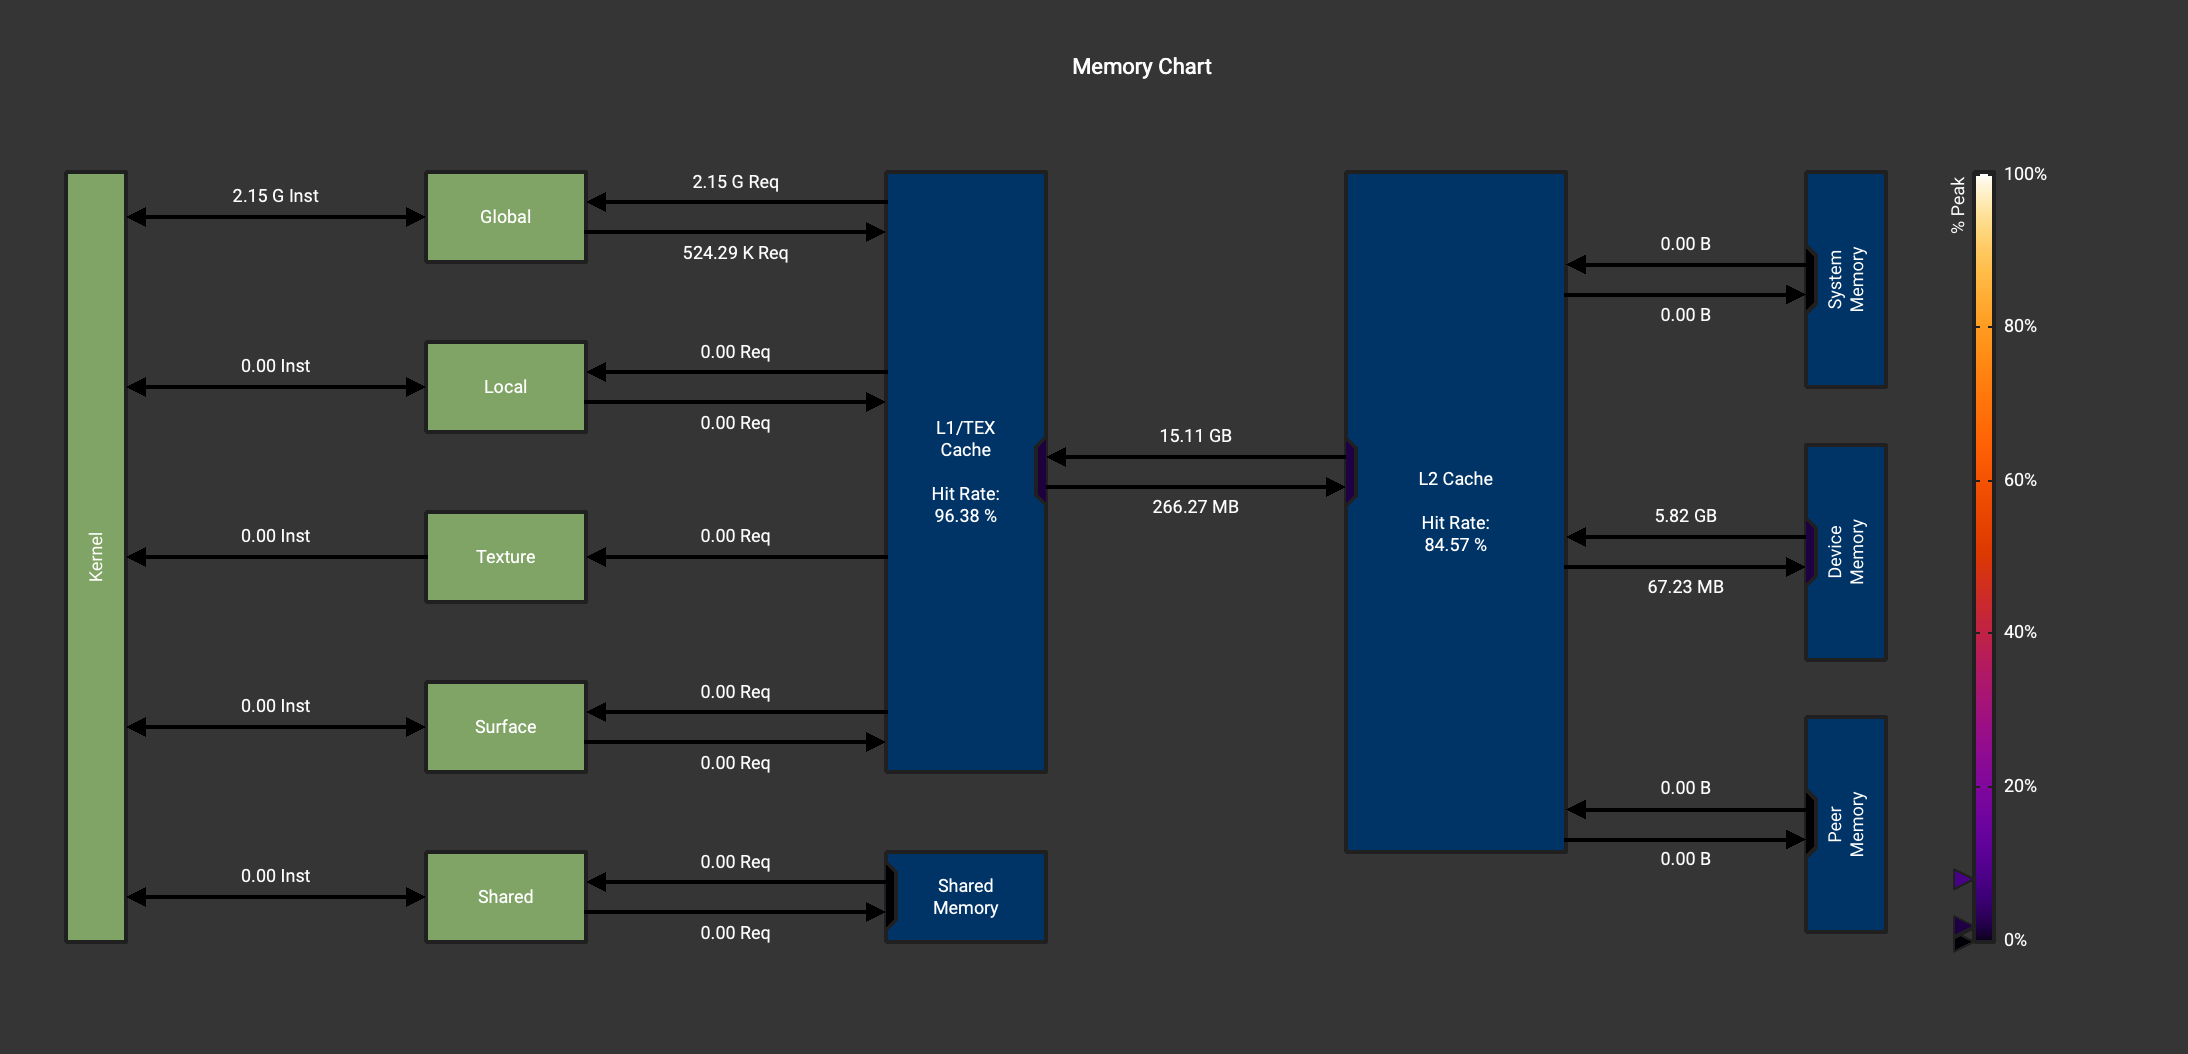


I am interested to see how the situation changes if I change the local accumulator to `float32` and make the memory access pattern more coalesced. Thus I will implement a new kernel with these changes and profile it again.

In [ ]:
%%writefile profiling/implementations/baseline_improved.py

from numba import cuda, float32
import math
import os
import pandas as pd
import numpy as np
import sys
import cupy as cp

pwd = os.getcwd()

def load_decompositions(
    filepath=f"{pwd}/data/images.pkl",
):
    if os.path.exists(filepath):
        return pd.read_pickle(filepath)
    return None

decompositions = load_decompositions()
if decompositions is None:
    print("No decompositions found. Run part2.py first.")
    sys.exit(1)

decomposition = max(decompositions.values(), key=lambda d: len(d["s"]))
U, S, VT = decomposition["u"], decomposition["s"], decomposition["vt"]

U_device = cp.array(U, dtype=cp.float32)
S_device = cp.array(S, dtype=cp.float32)
VT_device = cp.array(VT, dtype=cp.float32)

C = np.zeros((U.shape[0], VT.shape[1]), dtype=np.float32)

print(
    f"U shape: {U.shape}, S shape: {S.shape}, VT shape: {VT.shape}, C shape: {C.shape}"
)

k = min(U.shape[1], VT.shape[0]) // 3
print(f"Using k={k}")


# --- Kernel ---

BLOCK_SIZE = (16, 16)

threads_per_block = BLOCK_SIZE


# Updated:
blocks_per_grid = (
    math.ceil(VT.shape[1] / threads_per_block[0]),  # maps to grid idx: x (columns imu)
    math.ceil(U.shape[0] / threads_per_block[1]),  # maps to grid idx: y (rows imu)
)

print(f"Threads per block: {threads_per_block}, Blocks per grid: {blocks_per_grid}")

@cuda.jit
def rec(u, s, vt, C, k):
    # Updated understanding:
    # in the cuda grid we have blocks of threads, each block has a number of threads
    # each thread has a unique identifier (x, y) in the grid
    # x moves along the columns of the matrix, y moves along the rows
    # thus: x is the column index, y is the row index: we map columns to rows, and rows to columns of the output C

    y = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    x = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if x < u.shape[0] and y < vt.shape[1]:
        tmp = float32(0.0)
        for k_i in range(k):
            tmp += u[x, k_i] * s[k_i] * vt[k_i, y]
        C[x, y] = tmp

# --------------

start_time = cuda.event()
end_time = cuda.event()

start_time.record()
rec[blocks_per_grid, threads_per_block](U_device, S_device, VT_device, C, k)
end_time.record()

cuda.synchronize()
print(f"Done. Execution time: {start_time.elapsed_time(end_time)} ms")

We now remap the grid x axis to the columns of the output matrix (y-Axis) and the grid y axis to the rows of the output matrix (x-Axis). This way we can access the memory in a more coalesced way as consecutive threads in x-axis access consective columns of $V^T$ which was not the case before.

In [ ]:
!sudo /opt/nvidia/nsight-compute/2023.3.1/ncu \
  -o $(pwd)/profiling/profiles/baseline_improved -f \
  --nvtx \
  --call-stack \
  --target-processes all \
  --metrics all \
  --set full \
  $(pwd)/.venv/bin/python $(pwd)/profiling/implementations/baseline_improved.py 16 16

The uncoalesced memory access warning disappeared in NCU.

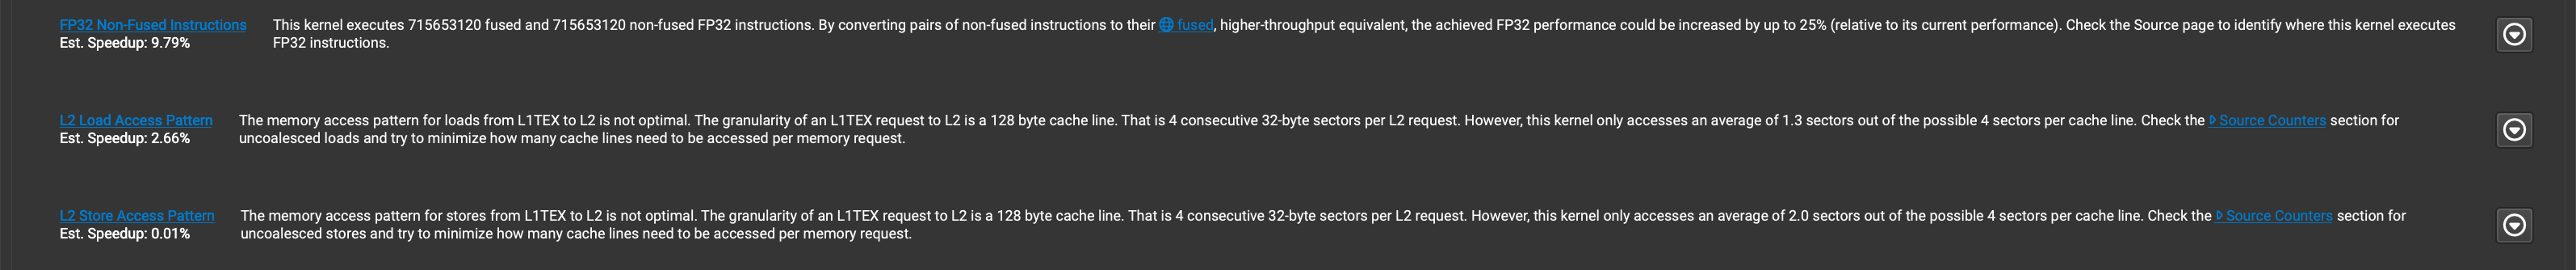

Comparing the details from the naive to the improved naive kernel we can see that the memory throughput is 1.5x faster in the improved naive kernel. This is a good indicator that the memory access pattern is now more coalesced and thus faster.

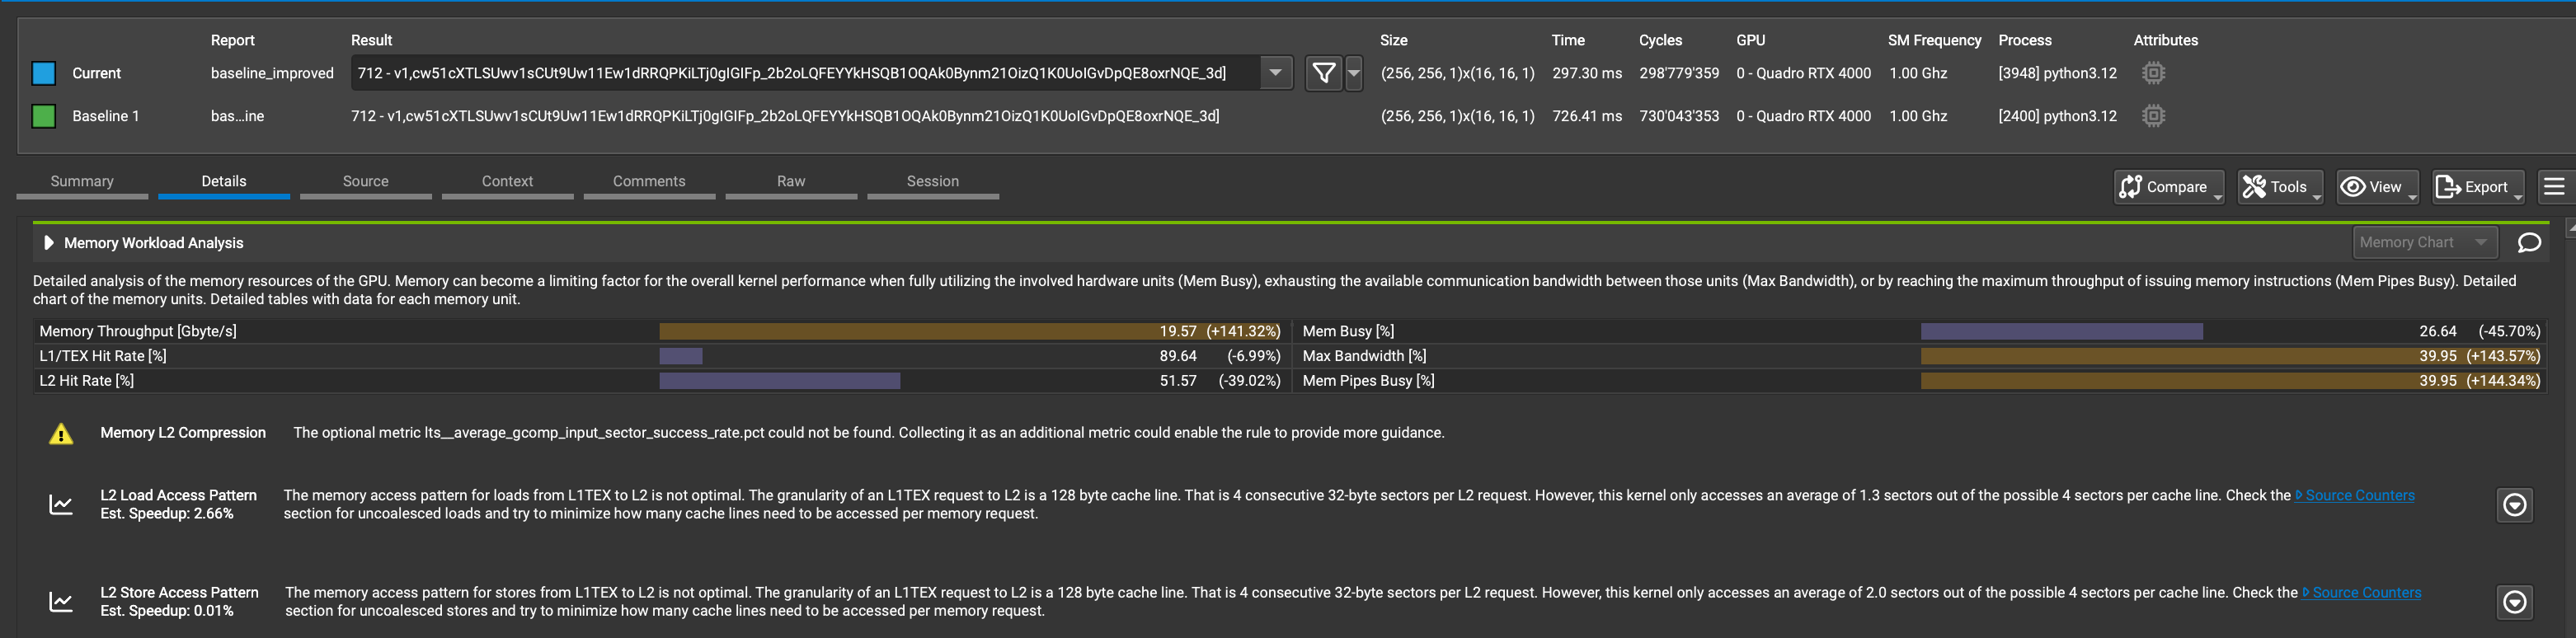

When analysing the workload the FP64 operations are now completly gone (blue being the improved kernel and green the naive kernel).

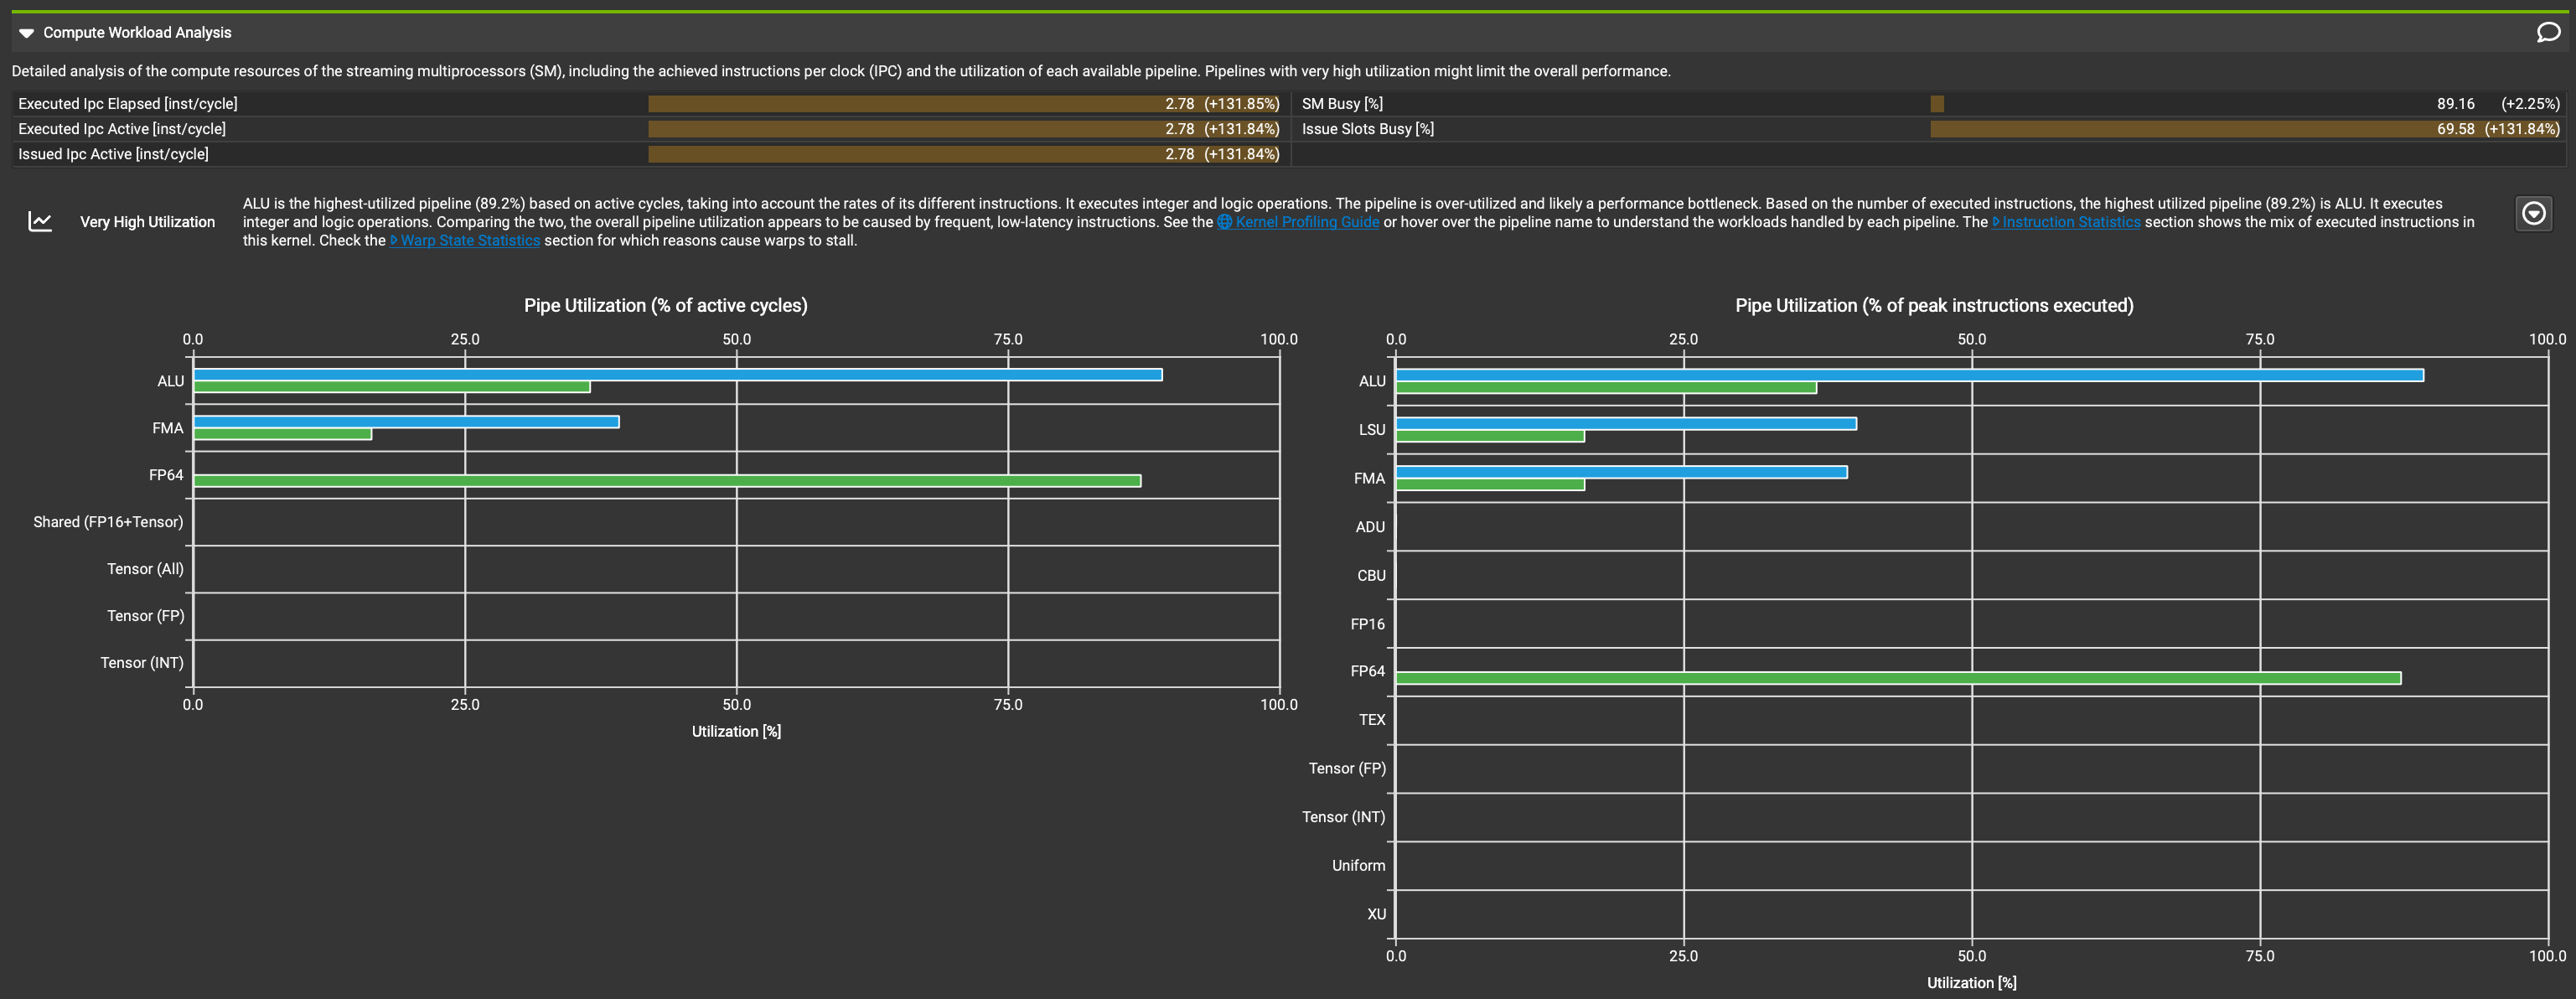

As the memory is accessed more coalesced now, the stalls (most likely due to memory latency) are reduced significantly.

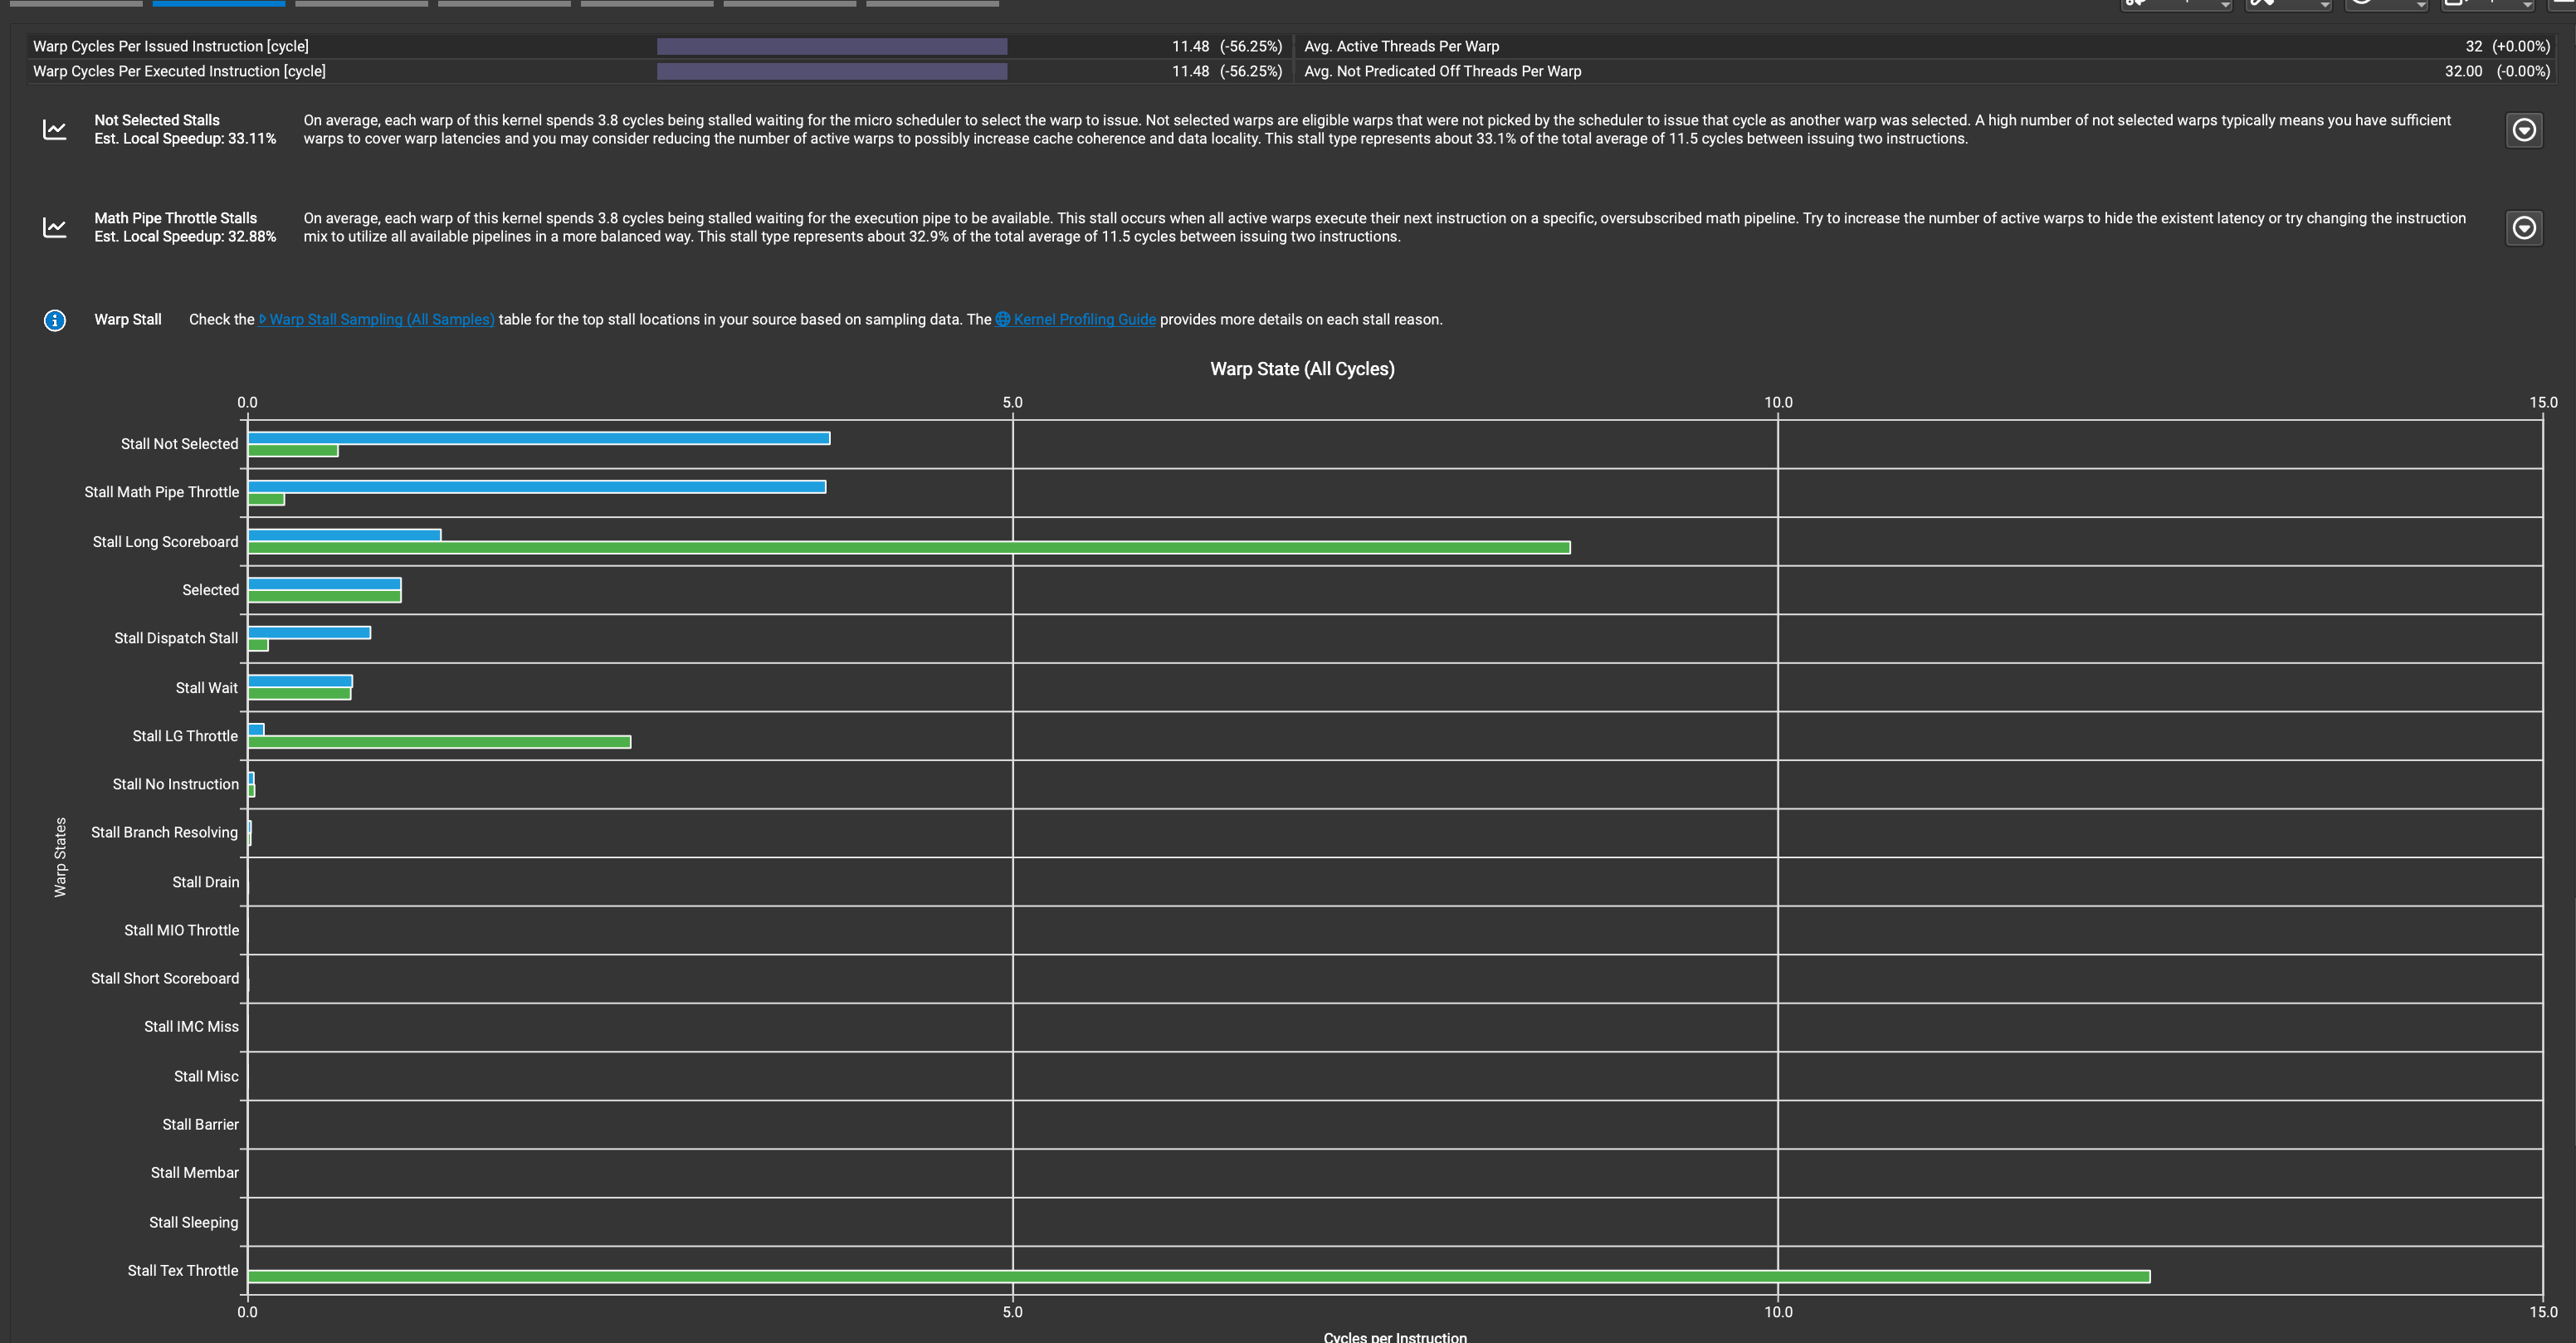

In addition to these changes, I will also look at the shared memory implementation and see if there are any bottlenecks that can be identified. I expect the shared memory implementation to see less global memory access.

In [ ]:
%%writefile profiling/implementations/shared_memory.py

from numba import cuda, float32
import math
import os
import pandas as pd
import numpy as np
import sys
import cupy as cp

pwd = os.getcwd()

def load_decompositions(
    filepath=f"{pwd}/data/images.pkl",
):
    if os.path.exists(filepath):
        return pd.read_pickle(filepath)
    return None

decompositions = load_decompositions()
if decompositions is None:
    print("No decompositions found. Run part2.py first.")
    sys.exit(1)

decomposition = max(decompositions.values(), key=lambda d: len(d["s"]))
U, S, VT = decomposition["u"], decomposition["s"], decomposition["vt"]

U_device = cp.array(U, dtype=cp.float32)
S_device = cp.array(S, dtype=cp.float32)
VT_device = cp.array(VT, dtype=cp.float32)

C = np.zeros((U.shape[0], VT.shape[1]), dtype=np.float32)

print(
    f"U shape: {U.shape}, S shape: {S.shape}, VT shape: {VT.shape}, C shape: {C.shape}"
)

k = min(U.shape[1], VT.shape[0]) // 3
print(f"Using k={k}")


# --- Kernel ---

TILE_SIZE = 16
BLOCK_SIZE = (TILE_SIZE, TILE_SIZE)

@cuda.jit
def rec(u, s, vt, C, k):
    # nice visual explanations: https://siboehm.com/articles/22/CUDA-MMM
    x, y = cuda.grid(2)
    if x >= u.shape[0] or y >= vt.shape[1]:
        return

    thread_x, thread_y = cuda.threadIdx.x, cuda.threadIdx.y

    u_shared = cuda.shared.array(shape=(TILE_SIZE, TILE_SIZE), dtype=float32)
    vt_shared = cuda.shared.array(shape=(TILE_SIZE, TILE_SIZE), dtype=float32)
    s_shared = cuda.shared.array(shape=(TILE_SIZE,), dtype=float32)

    max_blocks = math.ceil(
        k / TILE_SIZE
    )  # or cuda.gridDim.x as we tie the tile size to the block size
    acc = float32(0.0)
    for block_i in range(max_blocks):
        u_shared[thread_x, thread_y] = u[x, block_i * TILE_SIZE + thread_y]
        s_shared[thread_x] = s[block_i * TILE_SIZE + thread_x]
        vt_shared[thread_x, thread_y] = vt[block_i * TILE_SIZE + thread_x, y]

        cuda.syncthreads()

        for n in range(TILE_SIZE):
            acc += u_shared[thread_x, n] * s_shared[n] * vt_shared[n, thread_y]

        cuda.syncthreads()

    C[x, y] = acc


threads_per_block = BLOCK_SIZE
blocks_per_grid = (
    math.ceil(U.shape[0] / BLOCK_SIZE[0]),
    math.ceil(VT.shape[1] / BLOCK_SIZE[1]),
)

# --------------

start_time = cuda.event()
end_time = cuda.event()

start_time.record()
rec[blocks_per_grid, threads_per_block](U_device, S_device, VT_device, C, k)
end_time.record()

cuda.synchronize()
print(f"Done. Execution time: {start_time.elapsed_time(end_time)} ms")

In [ ]:
!sudo /opt/nvidia/nsight-compute/2023.3.1/ncu \
  -o $(pwd)/profiling/profiles/shared_memory -f \
  --nvtx \
  --call-stack \
  --target-processes all \
  --metrics all \
  --set full \
  $(pwd)/.venv/bin/python $(pwd)/profiling/implementations/shared_memory.py

If I compare the number of instructions between the naive baseline and the shared memory implementation we can see that the shared memory implementation has a lot less to the global memory (-93%). On the other side the shared memory is heavily used which is expected as we load the data into shared memory once and then reuse it. We have to note that the used shared memory implemntation doesnt have coalesced memory access patterns and thus the memory access is not optimal but it still highlights the performance gain of using shared memory although the memory access pattern is not optimal.

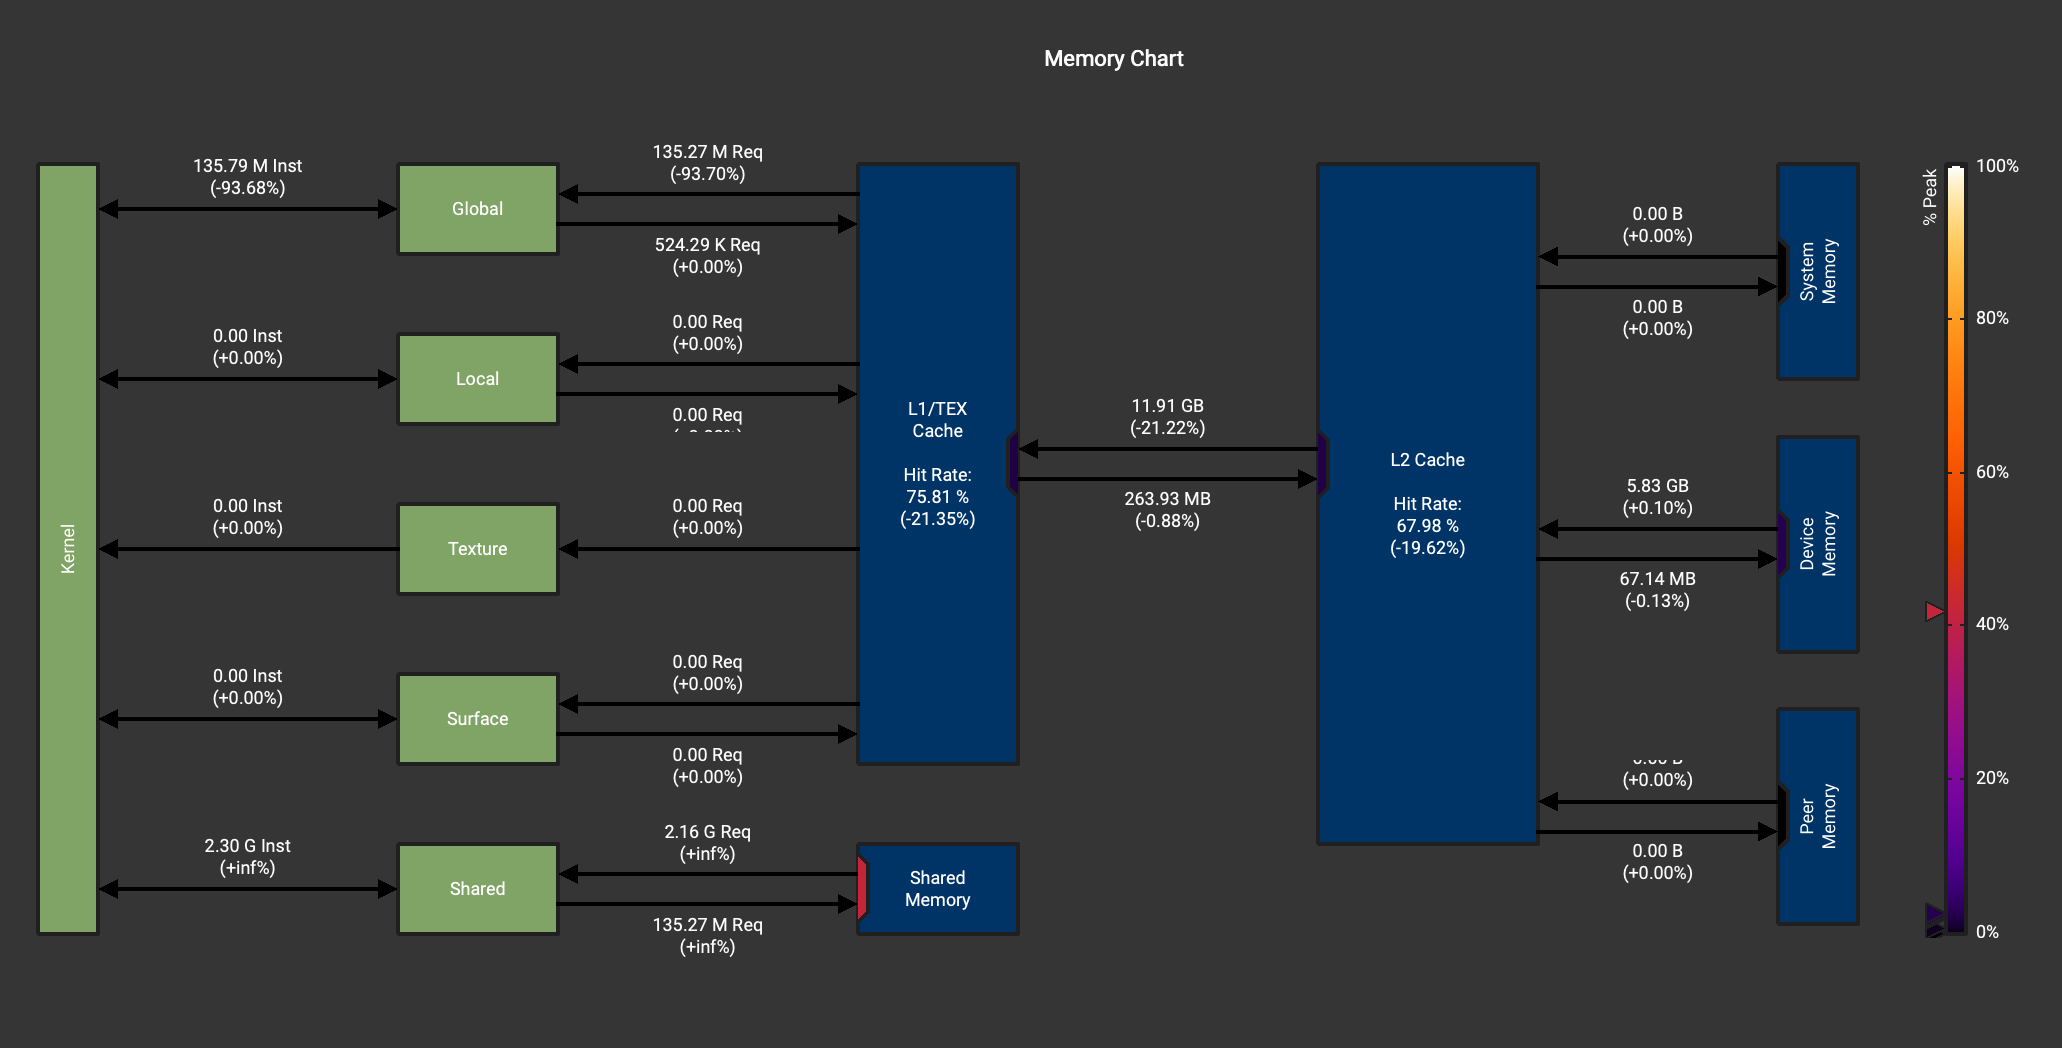

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

I run the reconstruction of a total of 10000 images with all equal size of $2^{10} \text{x} 2^{10}$ for simplicity. I do this across 10 workers, each with 6 exclusive streams to them. The code also supports the sequential reconstruction of the images for comparison later on. The execution time is measured for both the sequential and parallel reconstruction end-to-end.

I use streams, pinned memory, and threads:
1.	Streams (Execution Queues): Streams enable parallel operations like data transfer and computation, maximizing GPU utilization. Each stream independently handles data transfers and kernel operations, allowing overlap between processing and communication across multiple streams in a worker and across workers.
2.	Pinned Memory: Pinned memory accelerates data transfers between CPU and GPU by avoiding paging overhead, making PCIe bus usage efficient, especially with large input sizes. Pinned memory is allocated on the host and directly accessible by the GPU, eliminating the involvement of the CPU in data transfers which in theory further increases the performance and keeps the CPU free for other tasks.
3.	Threads: Threads manage tasks in concurrency (GIL), distribute work across streams, and coordinate resources, ensuring the CPU consistently feeds the GPU with new tasks. Although in Python threads are not real threads because of the GIL, they can still be used to manage the streams and the workers as the CPU is not involved in heavy computations but rather in the submission of tasks to the GPU. I have outlined further below the possible usage of the `multiprocessing` module to create real parallelism.

In [ ]:
%%writefile profiling/implementations/multiple.py

import math
import time
import os

import threading
from queue import Queue, Empty

from dataclasses import dataclass
from typing import List, Dict
import logging

import numpy as np
from argparse import ArgumentParser
from numba import cuda, float32
from numpy.linalg import svd
from PIL import Image

# --- Constants ---

LOG_LEVEL = logging.INFO
OUTPUT_DIR = "out"

BLOCK_SIZE_X, BLOCK_SIZE_Y = 16, 16
TOTAL_IMAGES = 10000
IMG_SIZE = 2**10

NUM_WORKERS = 10
NUM_STREAMS = 6

# ------------------

IMG = np.random.rand(IMG_SIZE, IMG_SIZE).astype(np.float32)
os.makedirs(OUTPUT_DIR, exist_ok=True)

logging.basicConfig(
    level=LOG_LEVEL, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logging.getLogger("numba.cuda.cudadrv.driver").setLevel(logging.ERROR)
logger = logging.getLogger(__name__)


@cuda.jit
def reconstruct(u, s, vt, C, k):
    y = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    x = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if x < u.shape[0] and y < vt.shape[1]:
        tmp = float32(0.0)
        for k_i in range(k):
            tmp += u[x, k_i] * s[k_i] * vt[k_i, y]
        C[x, y] = tmp


def save_to_disk(data, task_id):
    """Save the reconstructed result to disk as a PNG file."""
    # early return for testing but we could theoretically save the image to the disk or do whatever we want
    logger.debug(f"Processing task {task_id} result in callback")
    return

    is_close = np.allclose(data, IMG, atol=0.1)
    if not is_close:
        logger.error(
            f"Task {task_id} result is not close to the original image. Max diff: {np.max(np.abs(data - IMG))}"
        )

    image = Image.fromarray((data * 255).astype(np.uint8))
    image.save(f"out/reconstructed_{task_id}.png")
    logger.info(f"Saved task {task_id} result to disk.")


@dataclass
class GPUResources:

    streams: List[cuda.stream]
    device_arrays: List[Dict[str, cuda.devicearray.DeviceNDArray]]
    pinned_arrays: List[Dict[str, np.ndarray]]


class GPUProcessor:
    def __init__(self, shape_info: tuple):
        self.num_workers = NUM_WORKERS
        self.num_streams = NUM_STREAMS
        self.work_queue = Queue()
        self.shutdown_event = threading.Event()

        self.workers: List[threading.Thread] = []
        self.worker_resources: List[GPUResources] = []

        for i in range(NUM_WORKERS):
            logger.info(f"Initializing resources for worker {i}")
            self.worker_resources.append(self._initialize_gpu_resources(shape_info))
            logger.info(f"Resources initialized for worker {i}")

    def _initialize_gpu_resources(self, shape_info: tuple) -> GPUResources:
        """Initialize all GPU resources on the host thread"""
        M, N, K = shape_info

        streams = [cuda.stream() for _ in range(self.num_streams)]
        device_arrays = []
        pinned_arrays = []

        for _ in range(self.num_streams):
            d_arrays = {
                "U": cuda.device_array((M, K), dtype=np.float32),
                "S": cuda.device_array((K,), dtype=np.float32),
                "V": cuda.device_array((K, N), dtype=np.float32),
                "C": cuda.device_array((M, N), dtype=np.float32),
            }
            device_arrays.append(d_arrays)

            p_arrays = {
                "U": cuda.pinned_array((M, K), dtype=np.float32),
                "S": cuda.pinned_array((K,), dtype=np.float32),
                "V": cuda.pinned_array((K, N), dtype=np.float32),
                "C": cuda.pinned_array((M, N), dtype=np.float32),
            }
            pinned_arrays.append(p_arrays)

        return GPUResources(streams, device_arrays, pinned_arrays)

    def gpu_worker(self, worker_id: int, shape_info: tuple):
        """GPU worker thread that processes items from the work queue"""
        M, N, K = shape_info
        resources = self.worker_resources[worker_id]

        def stream_callback(stream, status, arg):
            task_id, slot_id = arg
            # do something with the result
            #result_data = resources.pinned_arrays[slot_id]["C"]
            #save_to_disk(result_data, task_id)

        logger.info(f"Worker {worker_id} started")
        counter = 0
        try:
            while not self.shutdown_event.is_set():
                try:
                    task = self.work_queue.get(timeout=1.0)
                    task_id, decomp = task

                    slot_id = counter % self.num_streams
                    counter += 1

                    stream = resources.streams[slot_id]
                    d_arrays = resources.device_arrays[slot_id]
                    p_arrays = resources.pinned_arrays[slot_id]

                    p_arrays["U"][:] = decomp["u"]
                    p_arrays["S"][:] = decomp["s"]
                    p_arrays["V"][:] = decomp["v"]
                    cuda.to_device(p_arrays["U"], to=d_arrays["U"], stream=stream)
                    cuda.to_device(p_arrays["S"], to=d_arrays["S"], stream=stream)
                    cuda.to_device(p_arrays["V"], to=d_arrays["V"], stream=stream)

                    grid_x = math.ceil(N / BLOCK_SIZE_X)
                    grid_y = math.ceil(M / BLOCK_SIZE_Y)
                    reconstruct[(grid_y, grid_x), (BLOCK_SIZE_X, BLOCK_SIZE_Y), stream](
                        d_arrays["U"], d_arrays["S"], d_arrays["V"], d_arrays["C"], K
                    )

                    d_arrays["C"].copy_to_host(p_arrays["C"], stream=stream)
                    stream.add_callback(stream_callback, (task_id, slot_id))

                    self.work_queue.task_done()
                    logger.debug(
                        f"Worker {worker_id} - completed task {task_id} - slot {slot_id} - counter {counter}"
                    )

                except Empty:
                    logger.info(f"Worker {worker_id} is idling...")
                    continue

                except Exception as e:
                    logger.error(
                        f"Error in worker {worker_id}: {str(e)}", exc_info=True
                    )

        except Exception as e:
            logger.error(f"Fatal error in worker {worker_id}: {str(e)}", exc_info=True)
        finally:
            logger.info(f"Worker {worker_id} shutting down...")

            logger.info(f"Worker {worker_id} cleaning up resources...")
            for stream in resources.streams:
                stream.synchronize()
            logger.info(f"Worker {worker_id} resources cleaned up")

            logger.info(f"Worker {worker_id} shutdown successfully")

    def start_processing(self, shape_info: tuple):
        for worker_id in range(self.num_workers):
            worker = threading.Thread(
                target=self.gpu_worker, args=(worker_id, shape_info)
            )
            worker.start()
            self.workers.append(worker)

    def add_work(self, decomp: Dict, task_id: int):
        self.work_queue.put((task_id, decomp))

    def stop(self):
        logger.info("Initiating shutdown...")
        self.shutdown_event.set()
        self.work_queue.join()

        for worker in self.workers:
            worker.join()

        logger.info("All workers shut down successfully")


def process_sequential(shape_info, decomp):
    M, N, K = shape_info

    U_pinned = cuda.pinned_array((M, K), dtype=np.float32)
    S_pinned = cuda.pinned_array((K,), dtype=np.float32)
    V_pinned = cuda.pinned_array((K, N), dtype=np.float32)
    C_pinned = cuda.pinned_array((M, N), dtype=np.float32)

    U_device = cuda.device_array((M, K), dtype=np.float32)
    S_device = cuda.device_array((K,), dtype=np.float32)
    V_device = cuda.device_array((K, N), dtype=np.float32)
    C_device = cuda.device_array((M, N), dtype=np.float32)

    start_time = time.time()
    for i in range(TOTAL_IMAGES):
        U_pinned[:] = decomp["u"]
        S_pinned[:] = decomp["s"]
        V_pinned[:] = decomp["v"]

        cuda.to_device(U_pinned, to=U_device)
        cuda.to_device(S_pinned, to=S_device)
        cuda.to_device(V_pinned, to=V_device)

        grid_x = math.ceil(N / BLOCK_SIZE_X)
        grid_y = math.ceil(M / BLOCK_SIZE_Y)
        reconstruct[(grid_y, grid_x), (BLOCK_SIZE_X, BLOCK_SIZE_Y)](
            U_device, S_device, V_device, C_device, K
        )

        C_device.copy_to_host(C_pinned)

    cuda.synchronize()

    end_time = time.time()
    total_time = end_time - start_time
    logger.info(
        f"Total time: {total_time:.2f}s, images / s: {TOTAL_IMAGES/total_time:.2f}, images: {TOTAL_IMAGES}"
    )


def main():
    logger.info(f"Num workers: {NUM_WORKERS}, Num streams / worker: {NUM_STREAMS}")

    parser = ArgumentParser()
    parser.add_argument(
        "--sequential", action="store_true", help="Run the computation sequentially"
    )
    args = parser.parse_args()
    sequential = args.sequential
    logger.info(f"Sequential: {sequential}")

    u, v, t = svd(IMG, full_matrices=False)
    decomp = {"u": u, "s": v, "v": t}

    M, K = decomp["u"].shape
    K_check, N = decomp["v"].shape

    if K_check != K:
        raise ValueError("Mismatch between U and V shapes in SVD.")

    shape_info = (M, N, K)
    logger.info(f"Shape info: {shape_info}")

    if sequential:
        process_sequential(shape_info, decomp)
        return

    start_time = time.time()
    processor = GPUProcessor(shape_info)
    try:
        for i in range(TOTAL_IMAGES):
            processor.add_work(decomp, i)

        processor.start_processing(shape_info)

        logger.info("Waiting for empty queue...")
        processor.work_queue.join()
        logger.info("Queue is empty")

    except Exception as e:
        logger.error(f"Error in main processing loop: {str(e)}", exc_info=True)
    finally:
        logger.info("Shutting down processor...")
        processor.stop()
        logger.info("Processor shutdown successfull")

    end_time = time.time()
    logger.info(
        f"Total time taken: {end_time - start_time:.2f} second - images / second: {TOTAL_IMAGES / (end_time - start_time):.2f}, images: {TOTAL_IMAGES}"
    )


if __name__ == "__main__":
    main()

In [ ]:
!$(pwd)/.venv/bin/python -u $(pwd)/profiling/implementations/multiple.py

> Result observed: Total time taken: 90.71 second - images / second: 110.24, images: 10000

In [ ]:
!sudo nsys profile \
  --trace cuda,osrt,nvtx \
  --gpu-metrics-device=all \
  --cuda-memory-usage true \
  --force-overwrite true \
  --output "$(pwd)/profiling/profiles/multiple" \
  $(pwd)/.venv/bin/python -u $(pwd)/profiling/implementations/multiple.py

To visualize the overlap between the different engines of the GPU, I will look at the process with the Nsight Systems profiler.

The top row is the summary of all the CUDA kernels and memory across all streams. The blue kernel executions happen while the pink and green memory transfers are happening effectively utilizing all the engines. This is a good indicator that the GPU is used efficiently and that the kernels are executed while the memory transfers are happening. Still I expected the kernels to overlap more with eachother. They still overalp but the overlap is minimal.

I actually tried to do it with the `multiprocessing` module but I had some issues with the profiler as I was not able to profile the CUDA executions when using this module. I think this is due to the arguments passed to the profiling command but I was not able to figure it out. I tried to follow the steps of this dicussion but did not succeed: https://forums.developer.nvidia.com/t/nsight-systems-does-not-profile-subprocess-via-fork-in-unistd-or-process-in-python-multiprocess-cuda-api/268038. This is why I ultimately sticked with the `threading` module for simplicity.

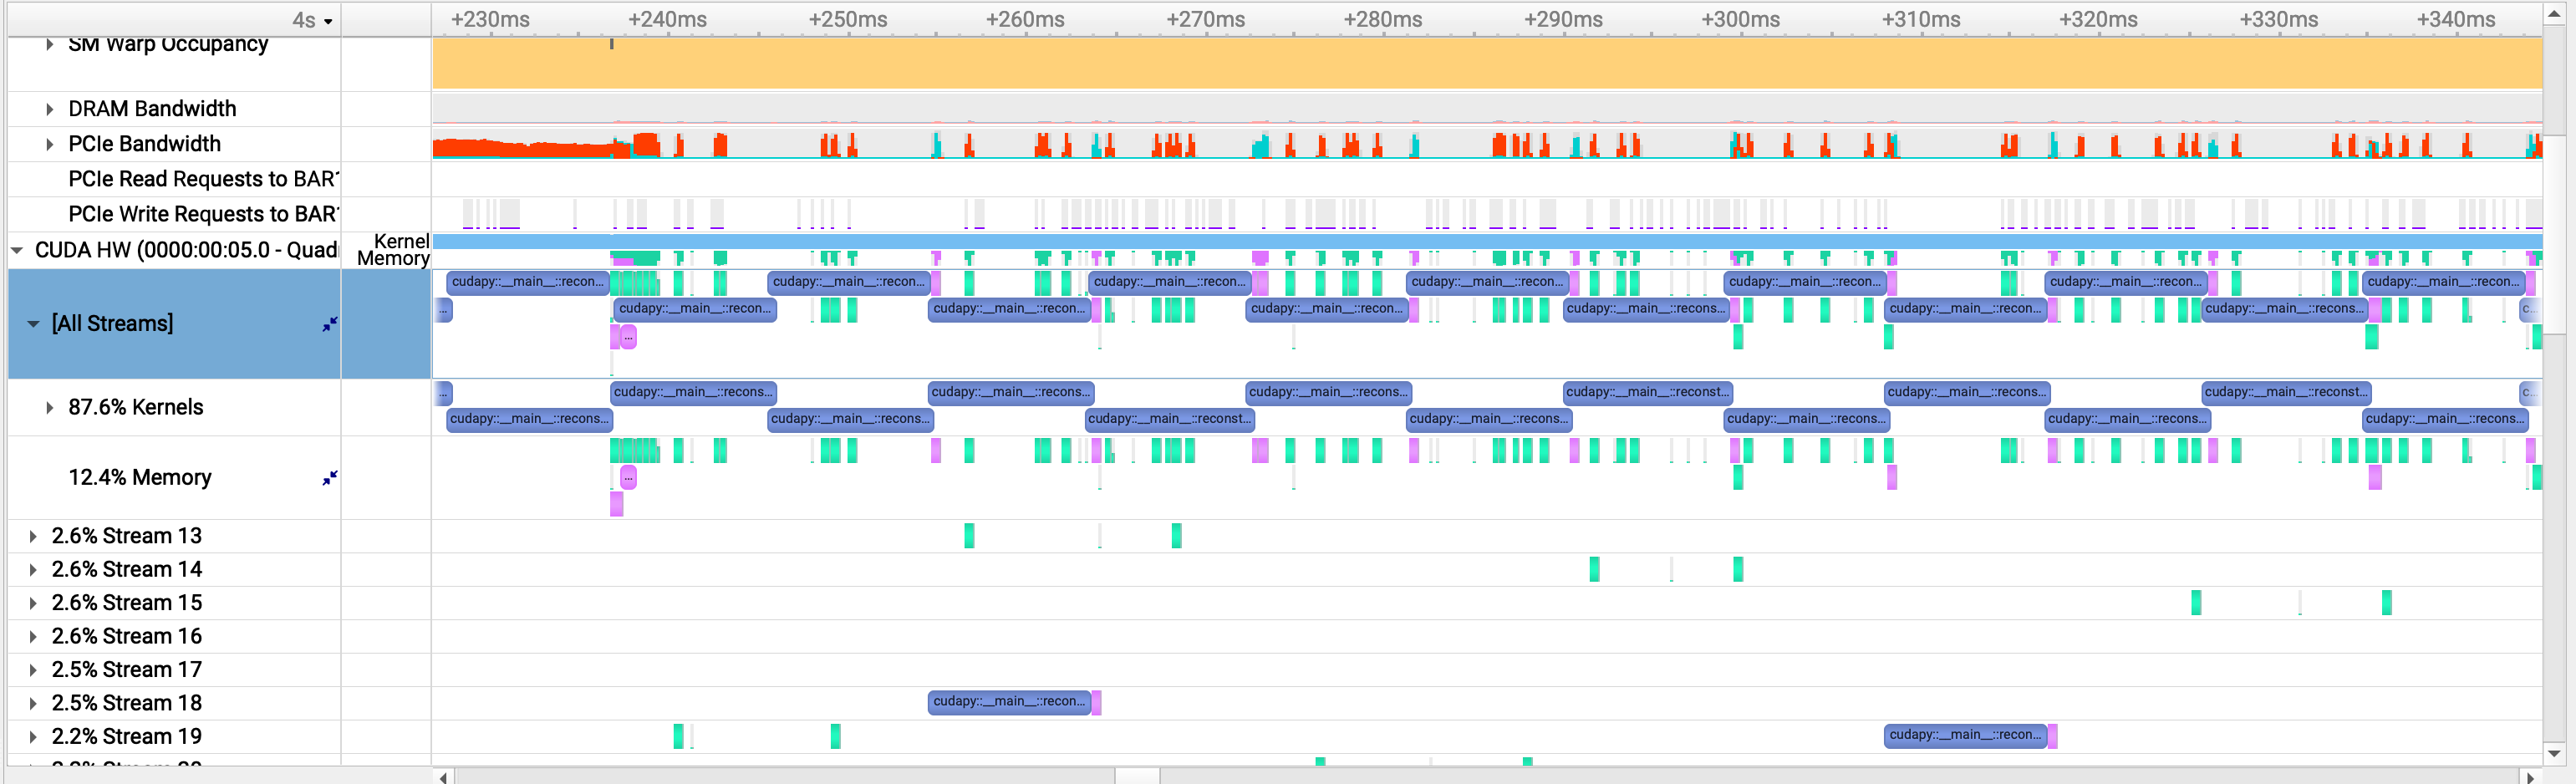

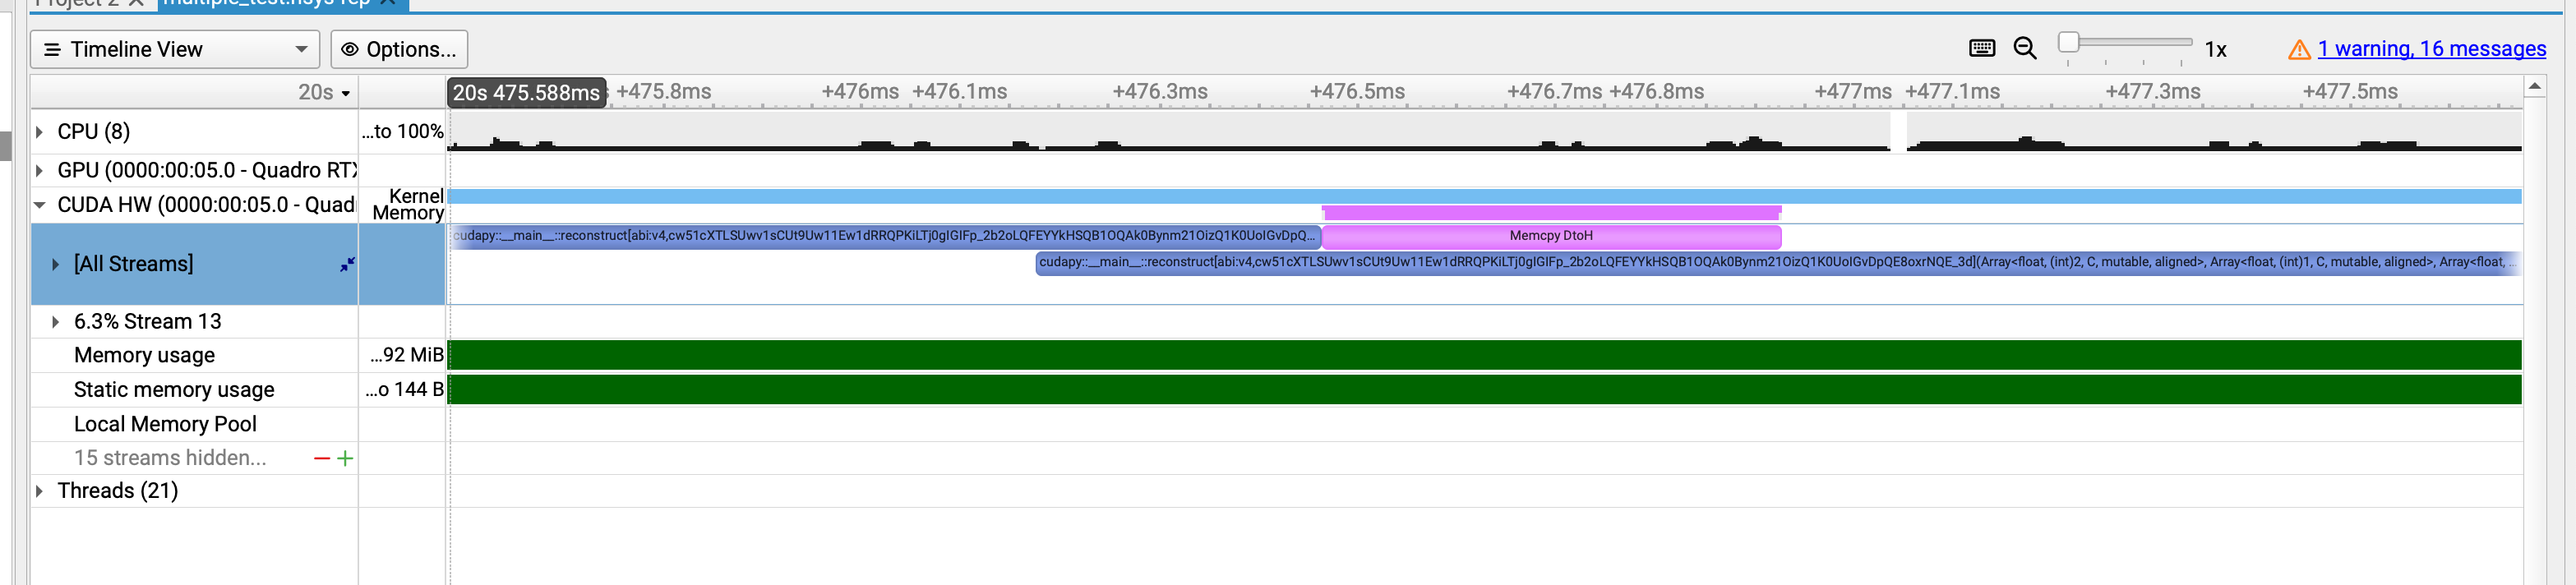

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

In [ ]:
!$(pwd)/.venv/bin/python -u $(pwd)/profiling/implementations/multiple.py --sequential

> Observed result: Total time: 132.31s, images / s: 75.58, images: 10000

<font color='blue'>


In my implementation, I observed a significant performance difference between sequential and parallel methods. The sequential approach took 132.31 seconds to process 10000 images (75.58 images/s), while the parallel implementation completed the task in 90.71 seconds (110.24 images/s), achieving a speedup of approximately $1.46$.

Amdahl's law explains that the speedup is limited by sequential components, such as data preparation or memory transfers, which create a ceiling for performance improvements. While the parallel fraction ($P$) is high, some unavoidable sequential operations and the overhead from managing streams and data transfers likely reduce the overall speedup. In the parallel implementation, the CPU is still involved in managing the streams and data transfers, which could be a bottleneck. The CPU is also responsible for submitting tasks to the GPU, which could introduce delays and limit the parallel performance. Also I have used the `threading` module which does not provide real parallelism due to the GIL in Python.

Gustafson's law suggests that scaling the workload should amplify parallel benefits, and the larger workload indeed demonstrates a clear advantage for the parallel implementation. However, the speedup of $1.46$ suggests inefficiencies that prevent reaching the theoretical maximum. I suspect that this could be related to the kernel implementation as we are using a fairly naive kernel which is not optimized too much.

</font>


#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


![](https://mermaid.ink/img/pako:eNqNVF1r20AQ_CuLIGCD8wf0ECgOhOJWxFFSQfHLRre2Dkt3yn24NSH_vXt3ku3Ypq1eJJ1m52ZntPee1VpQlmeW3jypmu4lbgx2KwV8oXda-e6VzEqllR6Nk7XsUTmYP74A2nibfEep4LkxhGJ6iVwGXKXNFpaePF0CqmJEkBlooLiEPaQdw-2edrK-wrQIgAUZRS1MnqjWyjrjazcdO7i5gWe0W0AhpJN6WOUmbu_uljl8EQIEl3W9tvG7hcnLDMoZ_JiC0-AagrfUxIFv0O2ibgu90TVZK9UGHO9kE67Vuoeqke1QD9KC0g6o690-QcJVFUnHo6y34PvIAJOo-Os9FNMjcnnLyKpgqNE7KWiAjmJHfeEqtCPQO9ZYFTN2L4e57vcg0OHn7oKzE7R7VYOPDbB5hJ2dngmMHM8GlV0z6ZlfzCNiOtBRp80eJoklqr8mitlmixy-oVd1A9sUXlTRGK20t-2JQQ8xKYaXjmMHc4yYN__nVovUfmUkr5zUkuA361s3upCkHykWY9el0-a8tENn5G-Y_1enIbJo_7DhK3LSvGujrTs49vcMkgeB6JDBVUHnrFfVxUDnKVC52TBXjW0bVfmeLY2_VQi4peO8HGcmVpa4oxMDhQx_Iq5dmIrP5UMXpMTJAJWNd0L_UuPonM5k6LKUG4Ut2AGWPh9_xCdqCS3F3FiE9oZJslnWkelQCj7d3kPJKuPh7WiV5fwoaI2sdpWt1AdDw0lXsuVZzhbSLDPab5osX2Nr-c33PCrj0XhY5fPmp9bj-8cfza63vw?type=png)


<font color='blue'>

This diagram illustrates the parallel reconstruction workflow, where the CPU enqueues tasks for worker threads, and each worker processes tasks asynchronously using streams. Decomposition data ( U, S, V ) is transferred to GPU memory, and the reconstruction kernel is launched asynchronously. Once the result ( C ) is computed, it is transferred back to the host memory, triggering a callback to save the result upon completion. The process ensures efficient GPU utilization with minimal synchronization, and workers continue polling the queue until all tasks are processed.

</font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>

Profiling to identify hotspots is crucial. only then can we decide where optimizations pay off. Minimizing overhead by reducing data transfers and removing unnecessary computations ensures high throughput. Exploiting parallelism effectively, whether via vectorization on CPU or massively parallel kernels on the GPU, delivers the largest performance gain.

</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>

We employed both SISD (Single Instruction, Single Data) on the CPU for matrix decomposition (SVD) and SIMT-like concepts (a form of SIMD/MIMD hybrid) on the GPU when launching large numbers of threads in parallel.

</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>

Primarily, the problem is CPU/GPU-bound. The large portion of time is spent computing matrix multiplications (or reconstructions), which are heavy numerical operations. Although there is some data transfer overhead (I/O from host to device), the core bottleneck lies in the matrix calculations and memory transfers within the context of these kernels, making it more compute-bound than I/O-bound.

</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>

A dedicated producer could generate or fetch image tasks and push them into a queue. Multiple consumers (GPU workers or threads managing GPU streams) pull tasks, perform reconstruction, and then store or return results. This pattern keeps the pipeline continuously fed and helps balance load between task generation and processing.

</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>

Using coalesced global memory access, reducing kernel launch overheads, and leveraging shared memory for data reuse are the main pillars. Employing appropriate block and grid dimensions—aligned with warp boundaries—further improves utilization. Lastly, overlapping computation with data transfers through streams or pinned memory when reconstruction multiple images is essential for high throughput.

</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>

The flow from naive to optimized kernels went well, highlighting the impact of memory access patterns and parallelization. Debugging GPU-specific issues and ensuring correct data transfers took longer than expected. Learning to apply best practices like coalesced access and shared memory was especially valuable, and it was surprising just how much difference small changes make. Additional insights into warp scheduling or advanced memory layouts (e.g., tiling) would have been beneficial. The questions mostly fit well; if changed, I might add explicit tasks about leveraging pinned memory or verifying coalesced access in detail to deepen practical understanding.

</font>